# Mission 1. 패션 스타일 이미지 분류

### 목차
- [1-1. 성별&스타일 통계표](#1-1)
    - [1-1-1. 통계표 결과](#1-1-1)
- [1-2. 성별&스타일 분류 모델](#1-2)
    - [1-2-1. 이미지 전처리](#1-2-1)
        - [1-2-1-1. 훈련이미지셋 배경제거 (u2net_human_seg)](#1-2-1-1)
        - [1-2-1-2. 처리 이미지 정합성 확인](#1-2-1-2)
        - [1-2-1-3. 처리중 손상된 이미지 재처리](#1-2-1-3)
        - [1-2-1-4. 배경 제거 결과 후 처리](#1-2-1-4)
        - [1-2-1-5. 이상 데이터 확인](#1-2-1-5)
        - [1-2-1-6. 배경 처리 고도화 모델 적용 (birefnet)](#1-2-1-6)
        - [1-2-1-7. 관심영역 추출 및 이미지 리사이징](#1-2-1-7)
        - [1-2-1-8. Validation Set에 동일 전처리 적용](#1-2-1-8)
    - [1-2-2. Pytorch 기반 ResNet-18 이미지 분류 모델](#1-2-2)
        - [1-2-2-1. 데이터셋 설계](#1-2-2-1)
        - [1-2-2-2. 불균형 클래스 처리](#1-2-2-2)
        - [1-2-2-3. 데이터 증강](#1-2-2-3)
        - [1-2-2-4. Baseline Training](#1-2-2-4)
        - [1-2-2-5. Augmentation Data Training](#1-2-2-5)
        - [1-2-2-6. Save & Load Model Inference](#1-2-2-6)
        
        
        

## 1-1. 

주어진 이미지 데이터의 파일 명은 다음과 같은 형식이다. <br> ```{W/T}_{이미지ID}_{시대별}_{스타일별}_{성별}.jpg``` <br> 이에 기반하여 “이미지 ID” 수 기준으로 “성별&스타일” 통계치를 아래 표 형식으로 기입한다.

In [7]:
# 필요한 라이브러리 불러오기
import torch
import os
import pandas as pd

In [8]:
# 데이터셋 경로 설정: 각 경로에서 이미지 파일 목록을 가져옵니다.
training_image = os.listdir('./data/training_image')   # 훈련 이미지 경로에서 파일 목록 가져오기
validation_image = os.listdir('./data/validation_image')  # 검증 이미지 경로에서 파일 목록 가져오기

# 데이터셋 파일명에서 속성 정보를 분리하여 데이터프레임 생성
column_name = ['W/T', 'image_id', 'period', 'style', 'Sex']  # 파일명에서 추출할 열 이름

# 훈련 데이터셋 파일명과 속성 정보로 데이터프레임 생성
training_data = {'file_name': training_image}  # 훈련 이미지 파일명을 딕셔너리로 생성
training_df = pd.DataFrame(training_data)  # 딕셔너리를 데이터프레임으로 변환
# 파일명에서 확장자(.jpg)를 제거하고 '_' 기준으로 나눈 후, 지정한 column_name에 맞춰 할당
training_df[column_name] = training_df['file_name'].str.replace('.jpg', '').str.split('_', expand=True)

# 검증 데이터셋 파일명과 속성 정보로 데이터프레임 생성
validation_data = {'file_name': validation_image}  # 검증 이미지 파일명을 딕셔너리로 생성
validation_df = pd.DataFrame(validation_data)  # 딕셔너리를 데이터프레임으로 변환
# 파일명에서 확장자(.jpg)를 제거하고 '_' 기준으로 나눈 후, 지정한 column_name에 맞춰 할당
validation_df[column_name] = validation_df['file_name'].str.replace('.jpg', '').str.split('_', expand=True)

# 결과 데이터프레임 출력
display(training_df, validation_df)

file_name W/T image_id period           style Sex
0        W_01752_00_metrosexual_M.jpg   W    01752     00     metrosexual   M
1           W_46417_70_military_W.jpg   W    46417     70        military   W
2        W_01509_00_metrosexual_M.jpg   W    01509     00     metrosexual   M
3           W_18951_50_feminine_W.jpg   W    18951     50        feminine   W
4     W_29485_10_sportivecasual_M.jpg   W    29485     10  sportivecasual   M
...                               ...  ..      ...    ...             ...  ..
4065        W_03060_50_feminine_W.jpg   W    03060     50        feminine   W
4066  W_00032_10_sportivecasual_M.jpg   W    00032     10  sportivecasual   M
4067  W_02918_10_sportivecasual_M.jpg   W    02918     10  sportivecasual   M
4068        W_08957_19_normcore_W.jpg   W    08957     19        normcore   W
4069         W_00465_50_classic_W.jpg   W    00465     50         classic   W

[4070 rows x 6 columns]

file_name W/T image_id period           style Sex
0    W_14468_10_sportivecasual_W.jpg   W    14468     10  sportivecasual   W
1          W_17239_19_normcore_M.jpg   W    17239     19        normcore   M
2       W_06895_00_metrosexual_M.jpg   W    06895     00     metrosexual   M
3          W_13354_50_feminine_W.jpg   W    13354     50        feminine   W
4          W_07018_19_normcore_M.jpg   W    07018     19        normcore   M
..                               ...  ..      ...    ...             ...  ..
946          T_21988_70_hippie_M.jpg   T    21988     70          hippie   M
947             W_28022_50_ivy_M.jpg   W    28022     50             ivy   M
948        W_00551_19_normcore_M.jpg   W    00551     19        normcore   M
949         W_03144_50_classic_W.jpg   W    03144     50         classic   W
950  W_28453_10_sportivecasual_M.jpg   W    28453     10  sportivecasual   M

[951 rows x 6 columns]

### 1-1-1.

통계표 결과(train, Validation)

In [9]:
# Train 데이터프레임(training_df)에서 'Sex'와 'style' 컬럼을 기준으로 그룹화하고, 각 그룹의 이미지 파일 수를 계산
# 'file_name' 컬럼의 개수를 세어 그룹별 이미지 파일 수를 나타냄
# 그룹별 파일 수를 기준으로 오름차순 정렬하고, 'count'라는 열 이름으로 데이터프레임 형태로 반환
training_df.groupby(['Sex', 'style'])['file_name'].count().sort_values(ascending=True).to_frame(name='count')

count
Sex style                
W   grunge             31
    military           33
    disco              37
    space              37
    popart             41
    lounge             45
    hiphop             48
    lingerie           55
    ecology            64
    punk               65
    cityglam           67
    athleisure         67
    classic            77
    genderless         77
    oriental           78
    hippie             91
    kitsch             91
    bodyconscious      95
    powersuit         120
    minimal           139
    normcore          153
    feminine          154
    sportivecasual    157
M   ivy               237
    hippie            260
    bold              268
    mods              269
    hiphop            274
    metrosexual       278
    sportivecasual    298
    normcore          364

In [10]:
# Validation 데이터프레임(validation_df)에서 'Sex'와 'style' 컬럼을 기준으로 그룹화하고, 각 그룹의 이미지 파일 수를 계산
# 'file_name' 컬럼의 개수를 세어 그룹별 이미지 파일 수를 나타냄
# 그룹별 파일 수를 기준으로 오름차순 정렬하고, 'count'라는 열 이름으로 데이터프레임 형태로 반환
validation_df.groupby(['Sex', 'style'])['file_name'].count().sort_values(ascending=True).to_frame(name='count')

count
Sex style                
W   lingerie            5
    popart              8
    hiphop              8
    lounge              8
    military            9
    disco              10
    grunge             10
    genderless         12
    punk               12
    hippie             14
    athleisure         14
    space              15
    ecology            17
    cityglam           18
    oriental           18
    normcore           20
    classic            22
    kitsch             22
    bodyconscious      23
    powersuit          34
    minimal            35
    feminine           44
    sportivecasual     48
M   normcore           51
    sportivecasual     52
    bold               57
    metrosexual        58
    hiphop             66
    ivy                79
    mods               80
    hippie             82

## 1-2. 

ResNet-18를 활용하여 "성별&스타일" 단위로 클래스 분류를 수행하고 Validation 데이터에 대한 정확도를 제시한다.

#### 1-2-1. 

이미지 전처리

In [11]:
import platform
import torch

print("Python version")
!python --version

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
Python 3.11.10

OS information
Linux-5.4.0-193-generic-x86_64-with-glibc2.31

Is GPU available?
True

GPU information
Mon Oct 28 21:07:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   32C    P8              16W / 230W |  24123MiB / 24564MiB |      0%      Default |
|                        

#### 1-2-1-1.

#### 1) [훈련이미지셋 배경제거 (u2net_human_seg)](https://github.com/xuebinqin/U-2-Net)

- U2net기반 모델의 사람 검출에 특화된 세그멘테이션 Fine-Tuning 모델을 이용하여 사람과 배경을 마스킹하고 불필요한 부분을 제거
- 주의 : 오랜 시간이 걸리므로 CPU자원을 최대한으로 끌어서 병렬처리를 진행

In [12]:
import os
import io
import multiprocessing
from rembg import remove, new_session
from PIL import Image
from tqdm import tqdm 

# 배경 제거 함수
def remove_background(args):
    image_path, output_dir = args  # unpacking 인자
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
    
    # 2. 배경 제거
    model_name = "u2net_human_seg"
    session = new_session(model_name)

    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

# 병렬 처리 함수
def process_images_in_parallel(image_paths, output_dir, num_workers=4):
    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 멀티프로세싱 풀 생성
    pool = multiprocessing.Pool(num_workers)
    
    # tqdm을 사용하여 진행 상황 표시
    # 각 인자를 튜플로 전달
    for _ in tqdm(pool.imap(remove_background, [(image_path, output_dir) for image_path in image_paths]), total=len(image_paths), leave=True, ncols=100, desc='Processing images'):
        pass
    
    # 풀 종료
    pool.close()
    pool.join()

if __name__ == "__main__":
    # 이미지 파일이 들어 있는 디렉토리와 출력 디렉토리 설정
    input_dir = './data/training_image'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/training_image_rembg'   # 처리된 이미지 저장할 디렉토리
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))][:1]
    
    # 병렬로 이미지 처리 (CPU 코어 수에 따라 조정 가능)
    process_images_in_parallel(image_paths, output_dir, num_workers=50)


Processing images: 100%|██████████████████████████████████████████████| 1/1 [00:03<00:00,  3.93s/it]


#### 1-2-1-2.

#### 2) 처리 이미지 정합성 확인

- 훈련 데이터 개수와 처리된 이미지의 수가 맞는지 확인하고, 도중에 중단되거나 오류가 있는 파일이 없는지 확인

In [13]:
import os
import sys

def get_file_list(path):
    file_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_list.append(file)
    return file_list

training_image_list = get_file_list('data/training_image')
print(len(training_image_list))
rembg_image_list = get_file_list('data/training_image_rembg')
print(len(training_image_list))

4070
4070


In [14]:
import os
from PIL import Image
from tqdm import tqdm

def find_corrupted_images(input_dir):
    corrupted_images = []
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_path in tqdm(image_paths, ncols=100, leave=True):
        try:
            # 이미지 열기 (손상된 파일일 경우 예외 발생)
            with Image.open(image_path) as img:
                img.verify()  # 이미지 파일 검증
        except Exception as e:
            # 손상된 이미지 목록에 추가
            image_name  = os.path.basename(image_path)
            corrupted_images.append((image_name))
    
    return corrupted_images

if __name__ == "__main__":
    input_dir = './data/training_image_rembg'  # 손상된 파일을 확인할 디렉토리
    corrupted_images = find_corrupted_images(input_dir)
    
    if corrupted_images:
        print("손상된 이미지 파일:")
        for img_path in corrupted_images:
            print(f"{img_path}")
    else:
        print("손상된 이미지 파일이 없습니다.")

100%|████████████████████████████████████████████████████████| 4070/4070 [00:00<00:00, 19195.19it/s]

손상된 이미지 파일이 없습니다.


#### 1-2-1-3.

#### 3) 처리중 손상된 이미지 재처리

In [15]:

input_dir = './data/training_image'  # 처리할 원본 이미지가 있는 디렉토리
output_dir = './data/training_image_rembg'   # 처리된 이미지 저장할 디렉토리

# output_dir에서 손상된 파일 리스트 찾기
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")
# 손상된 파일 리스트를 기준으로 input_dir의 파일 경로 리스트 만들기
valid_image_paths = [os.path.join(input_dir, fname) for fname in corrupted_images if os.path.exists(os.path.join(input_dir, fname))]
# # 손상된 파일만 다시 처리
if valid_image_paths:
    process_images_in_parallel(valid_image_paths, output_dir, num_workers=4)



100%|████████████████████████████████████████████████████████| 4070/4070 [00:00<00:00, 24128.74it/s]

손상된 파일 수: 0


In [16]:
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")

100%|████████████████████████████████████████████████████████| 4070/4070 [00:00<00:00, 24054.21it/s]

손상된 파일 수: 0


#### 1-2-1-4.

#### 4) 배경 제거 결과 후 처리

- 배경을 제거하면서 잘못된 검출로 패션 데이터도 지워버릴 수 있기때문에 검증이 필요
- 배경을 제거하고 흰색을 마스킹했기때문에 이미지에서 흰색 픽셀의 비율을 검출해 과다하게 많은 흰색 픽셀이 검출되는지 확인 
- 이상치의 기준이 되는 임계값을 찾기 위해 이미지의 흰색 픽셀 비율을 데이터프레임화 하고 Boxplot으로 살펴봄

Calculating white pixel percentage: 100%|███████████████████████| 4070/4070 [00:47<00:00, 86.32it/s]


image_path  white_pixel_ratio
0     ./data/training_image_rembg/W_01752_00_metrose...           0.775500
1     ./data/training_image_rembg/W_46417_70_militar...           0.758449
2     ./data/training_image_rembg/W_01509_00_metrose...           0.777762
3     ./data/training_image_rembg/W_18951_50_feminin...           0.576494
4     ./data/training_image_rembg/W_29485_10_sportiv...           0.622438
...                                                 ...                ...
4065  ./data/training_image_rembg/W_03060_50_feminin...           0.695795
4066  ./data/training_image_rembg/W_00032_10_sportiv...           0.803211
4067  ./data/training_image_rembg/W_02918_10_sportiv...           0.785070
4068  ./data/training_image_rembg/W_08957_19_normcor...           0.868775
4069  ./data/training_image_rembg/W_00465_50_classic...           0.482949

[4070 rows x 2 columns]

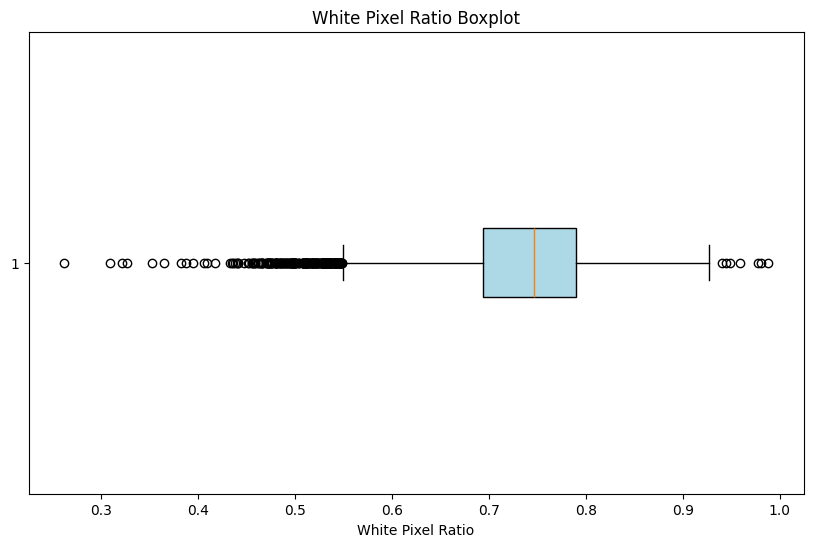

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import multiprocessing

def calculate_white_pixel_percentage_and_path(image_path):
    """
    단일 이미지에서 하얀색 픽셀이 차지하는 비율을 계산하는 함수.
    
    Args:
        image_path (str): 이미지 파일 경로
        
    Returns:
        tuple: 이미지 경로와 하얀색 픽셀 비율
    """
    # 이미지 열기 및 RGB로 변환
    image = Image.open(image_path).convert('RGB')
    
    # 이미지를 NumPy 배열로 변환
    image_np = np.array(image)
    
    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return (image_path, white_ratio)  # 경로와 비율 둘 다 반환

def process_image(image_path):
    """
    multiprocessing에서 사용될 개별 이미지 처리 함수.
    """
    return calculate_white_pixel_percentage_and_path(image_path)

def create_white_pixel_dataframe_parallel(image_paths, num_workers=4):
    """
    병렬 처리를 통해 이미지 경로 리스트를 받아 흰색 픽셀 비율을 계산하고 데이터프레임 생성.
    
    Args:
        image_paths (list): 이미지 파일 경로 리스트
        num_workers (int): 병렬 처리에 사용할 워커 수
        
    Returns:
        DataFrame: 이미지 경로와 흰색 픽셀 비율을 포함한 데이터프레임
    """
    with multiprocessing.Pool(num_workers) as pool:
        # 병렬 처리 진행 상황을 tqdm으로 표시
        results = list(tqdm(pool.imap(process_image, image_paths), 
                            total=len(image_paths), desc="Calculating white pixel percentage", ncols=100, leave=True))
    
    # 결과를 바탕으로 데이터프레임 생성
    df = pd.DataFrame(results, columns=["image_path", "white_pixel_ratio"])  # 2개의 열로 설정
    
    return df

def plot_white_pixel_boxplot(df, output_path=None):
    """
    흰색 픽셀 비율의 boxplot을 그리는 함수. 주피터 노트북에 표시하거나 파일로 저장.
    
    Args:
        df (DataFrame): 흰색 픽셀 비율을 포함한 데이터프레임
        output_path (str): 저장할 파일 경로 (지정하지 않으면 노트북에 표시)
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot(df['white_pixel_ratio'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title('White Pixel Ratio Boxplot')
    plt.xlabel('White Pixel Ratio')
    
    if output_path:
        # 이미지 파일로 저장
        plt.savefig(output_path)
        plt.close()
    else:
        # 주피터 노트북에 표시
        plt.show()

if __name__ == "__main__":
    # 배경 제거된 이미지가 저장된 디렉토리
    input_dir = './data/training_image_rembg'

    # 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 병렬로 흰색 픽셀 비율 계산 후 데이터프레임 생성
    df = create_white_pixel_dataframe_parallel(image_paths, num_workers=50)
    
    # 데이터프레임 저장 (필요한 경우)
    display(df)
    
    # boxplot 그리기
    plot_white_pixel_boxplot(df)

IQR Range가 0.7~8에 걸쳐있는 것으로 보아 많은 이미지가 사람이 작게 표현되어서 흰색비율이 높게 나오는 것으로 보임.  
일단, 이상치로 보이는 데이터를 거르기 위해 범위를 벗어난 90% 이상이 흰색 픽셀인 그림을 필터링 해봄.

In [18]:
import os
import numpy as np
from PIL import Image
import multiprocessing
from tqdm import tqdm

def is_anomalous(image_path, threshold=0.9):
    """
    배경 제거된 이미지에서 흰색 픽셀이 차지하는 비율이 특정 임계값을 넘으면 True를 반환.
    """
    image = Image.open(image_path).convert('RGB')  # 이미지 열기
    image_np = np.array(image)  # 이미지를 NumPy 배열로 변환

    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return image_path if white_ratio > threshold else None  # 임계값 초과 시 이상치로 판단

def process_image(image_path_threshold_tuple):
    """
    Tuple을 받아 is_anomalous를 실행하는 함수. 
    multiprocessing을 사용할 때 필요.
    """
    image_path, threshold = image_path_threshold_tuple
    return is_anomalous(image_path, threshold)

def find_anomalous_images_parallel(image_paths, threshold=0.9, num_workers=4):
    """
    병렬로 이상치 이미지를 찾는 함수. tqdm으로 진행 상황을 표시.
    """
    # 각 이미지 경로와 threshold를 튜플로 묶어서 전달
    path_threshold_tuples = [(img, threshold) for img in image_paths]
    
    with multiprocessing.Pool(num_workers) as pool:
        # tqdm으로 병렬처리 진행 상황 표시
        results = list(tqdm(pool.imap(process_image, path_threshold_tuples), 
                            total=len(image_paths), desc="Checking for anomalies", ncols=100, leave=True))
    
    # 이상치 이미지만 필터링
    anomalous_images = [res for res in results if res is not None]
    
    return anomalous_images

def calculate_white_pixel_percentage(image_path):
    """
    단일 이미지에서 하얀색 픽셀이 차지하는 비율을 계산하는 함수.
    
    Args:
        image_path (str): 이미지 파일 경로
        
    Returns:
        float: 하얀색 픽셀 비율 (0.0 ~ 1.0)
    """
    # 이미지 열기 및 RGB로 변환
    image = Image.open(image_path).convert('RGB')
    
    # 이미지를 NumPy 배열로 변환
    image_np = np.array(image)
    
    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return white_ratio


if __name__ == "__main__":
    # 배경 제거된 이미지가 저장된 디렉토리
    input_dir = './data/training_image_rembg'

    # 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 병렬로 이상치 탐지 (임계값과 워커 수는 필요에 따라 조정 가능)
    anomalies = find_anomalous_images_parallel(image_paths, threshold=0.9, num_workers=50)
    
    # 이상치로 판단된 이미지 출력
    if anomalies:
        print("Anomalous images found:", len(anomalies))
    else:
        print("No anomalies found.")


Checking for anomalies: 100%|███████████████████████████████████| 4070/4070 [00:44<00:00, 91.47it/s]


Anomalous images found: 23


#### 1-2-1-5.

#### 5) 이상 데이터 확인

직접 데이터를 확인해보았는데, 확실히 배경 분리가 정상적으로 이루어지지 않은 그림들이 보인다.

배경과 사람은 올바르게 분리됬지만 사람이 배경에 비해 많이 작을경우에도 검출되어서

이 방식으로 이상치만을 완벽히 탐색하긴 어려움.

In [19]:
anomalies

['./data/training_image_rembg/W_07271_10_sportivecasual_M.jpg',
 './data/training_image_rembg/W_24352_70_hippie_M.jpg',
 './data/training_image_rembg/W_01154_10_athleisure_W.jpg',
 './data/training_image_rembg/W_07418_50_feminine_W.jpg',
 './data/training_image_rembg/W_09008_10_sportivecasual_W.jpg',
 './data/training_image_rembg/W_09533_90_grunge_W.jpg',
 './data/training_image_rembg/W_11726_50_feminine_W.jpg',
 './data/training_image_rembg/W_11538_90_kitsch_W.jpg',
 './data/training_image_rembg/W_07344_10_sportivecasual_M.jpg',
 './data/training_image_rembg/W_14310_80_powersuit_W.jpg',
 './data/training_image_rembg/W_02060_10_athleisure_W.jpg',
 './data/training_image_rembg/W_02170_50_feminine_W.jpg',
 './data/training_image_rembg/W_08040_90_kitsch_W.jpg',
 './data/training_image_rembg/T_08918_19_normcore_W.jpg',
 './data/training_image_rembg/W_04319_90_hiphop_M.jpg',
 './data/training_image_rembg/W_04994_60_popart_W.jpg',
 './data/training_image_rembg/W_07759_00_cityglam_W.jpg',
 '.

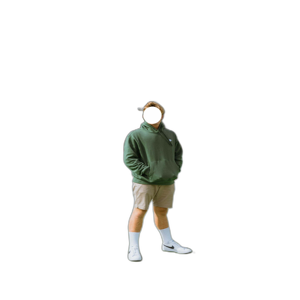

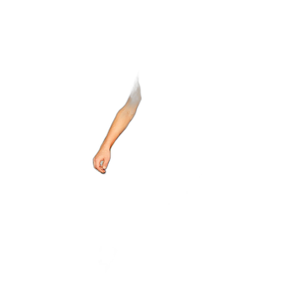

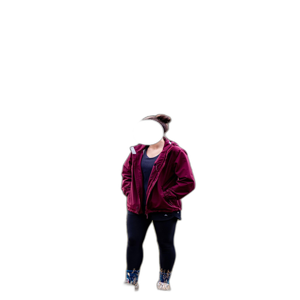

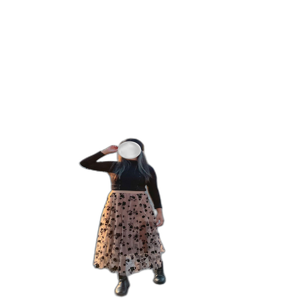

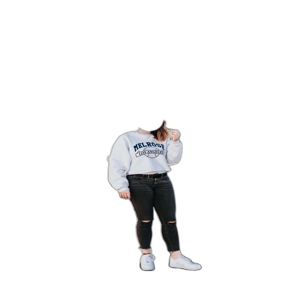

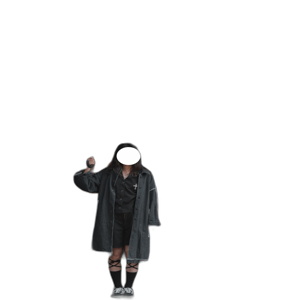

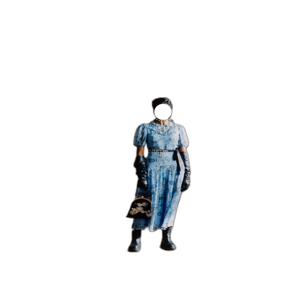

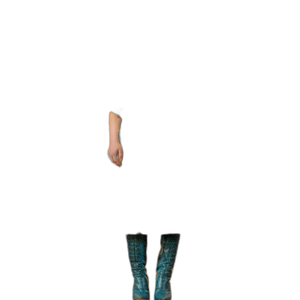

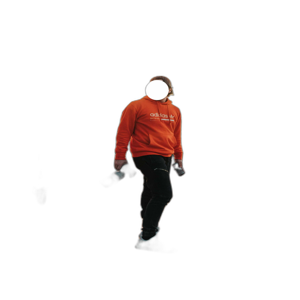

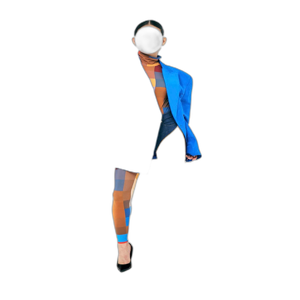

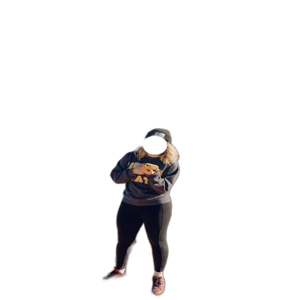

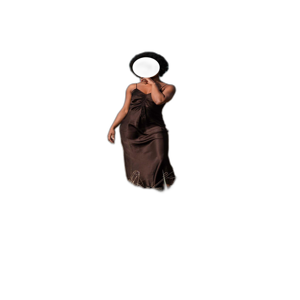

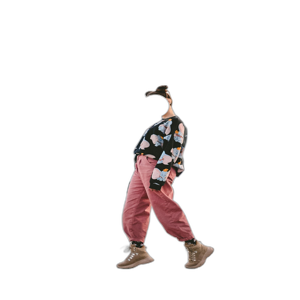

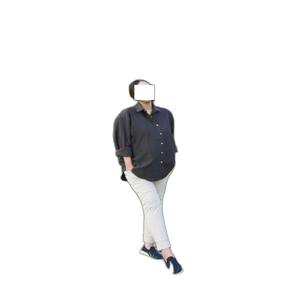

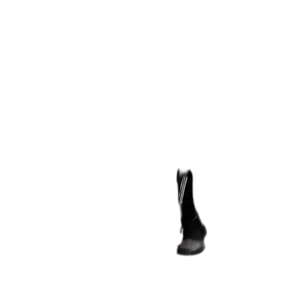

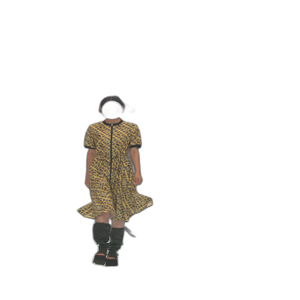

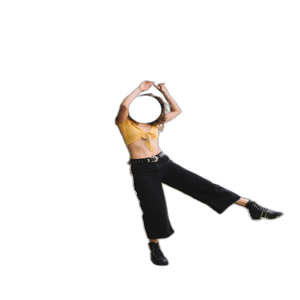

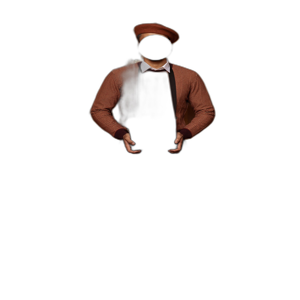

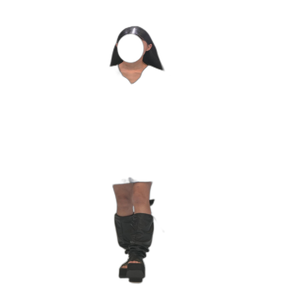

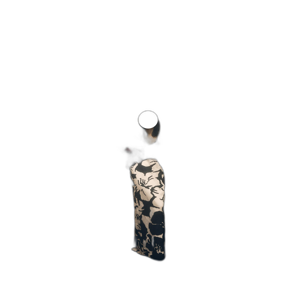

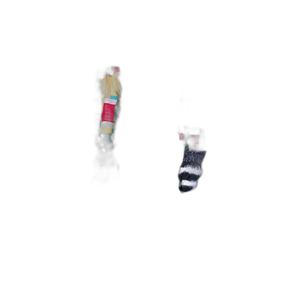

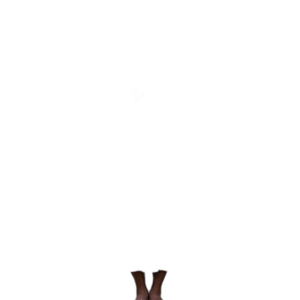

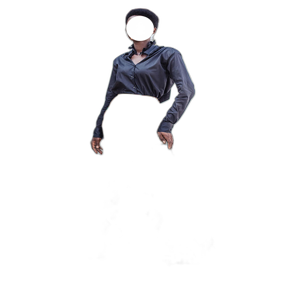

In [20]:
from IPython.display import display, Image
from PIL import Image as PILImage

# 이미지 표시
for path in anomalies:
    img = PILImage.open(path)  # 이미지 열기
    img = img.resize((300, 300))  # 이미지 리사이징 (300x300)
    display(img)  # 이미지 표시

#### 1-2-1-6.

#### 6) 배경 처리 고도화 모델 적용

분리가 제대로 안되는 그림들이 있는걸로 보아 U2net기반 모델의 한계가 있어 잘못 분리된 이미지에 대해 훨씬 좋은 성과를 보이고 있는 birefnet 구조의 모델을 사용해봄.

**birefnet은 2024년 DIS(Depth Image Segmentation, 깊이 정보를 사용하는 이미지 세분화 작업), COD(Camouflaged Object Detection, 위장된 객체를 탐지하는 작업), HRSOD(High-Resolution Salient Object Detection, 고해상도 이미지를 기반으로 주목할 만한 객체를 탐지하는 작업)에서 우수한 성과로 SOTA를 달성한 Image Segmentation모델임.**

다만, 좋은만큼 무거운 모델이라 1장 처리에 10초가 걸리고 CPU모델이 아닌 GPU모델이기에 병렬 계산을 하려면 여러 GPU가 있어야 함.

In [21]:
import os
import io
from rembg import remove, new_session
from PIL import Image
def remove_background_single(image_path, output_dir, session):
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
        
    # 2. 배경 제거
    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

if __name__ == "__main__":
    # 단일 이미지 파일 경로와 출력 디렉토리 지정
    output_dir = './data/training_image_rembg_anormal'              # 저장할 디렉토리

    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 배경 제거 및 처리된 이미지 저장
    model_name = "birefnet-portrait"
    session = new_session(model_name)
    anomal_train_path = [path.replace('training_image_rembg', 'training_image') for path in anomalies]
    for image_path in tqdm(anomal_train_path, leave=True, ncols=100):
        remove_background_single(image_path, output_dir, session=session)

100%|███████████████████████████████████████████████████████████████| 23/23 [09:23<00:00, 24.48s/it]


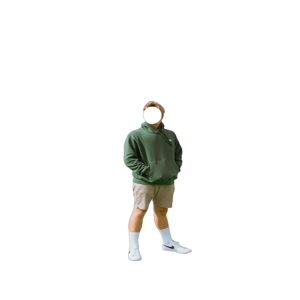

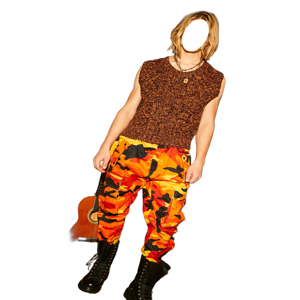

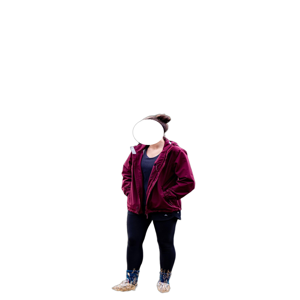

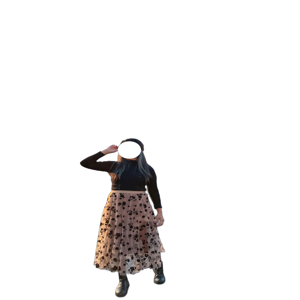

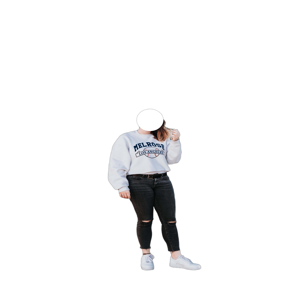

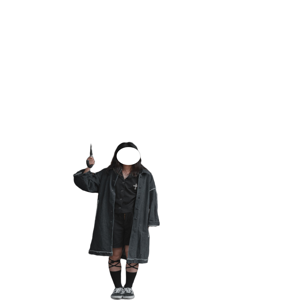

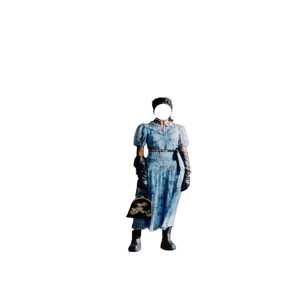

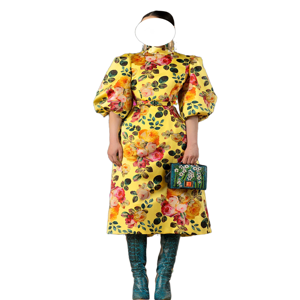

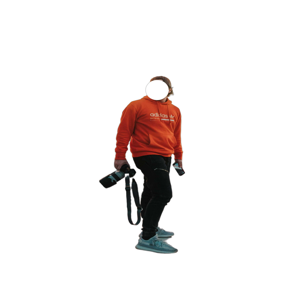

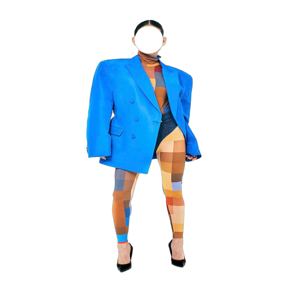

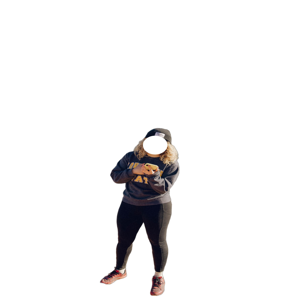

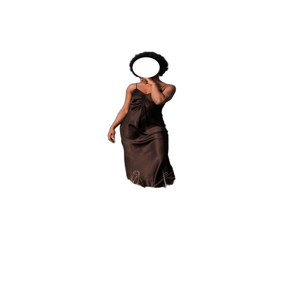

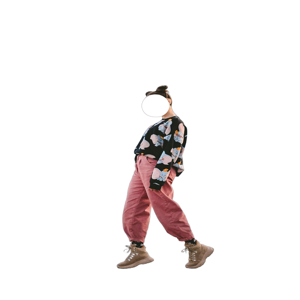

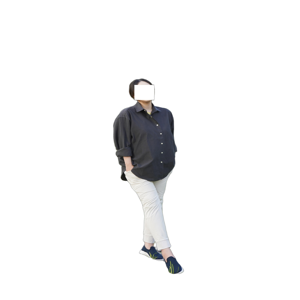

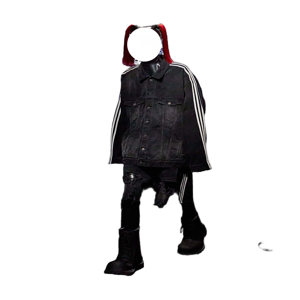

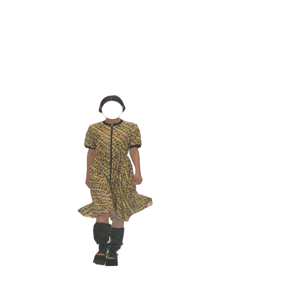

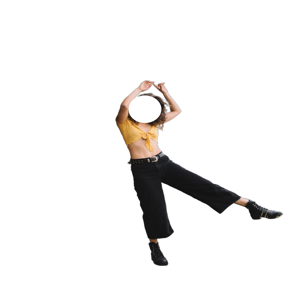

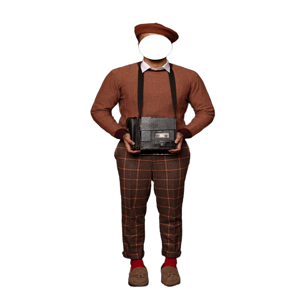

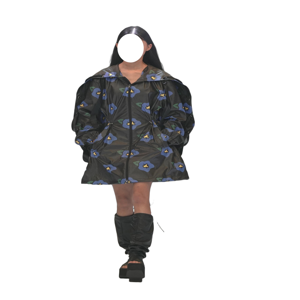

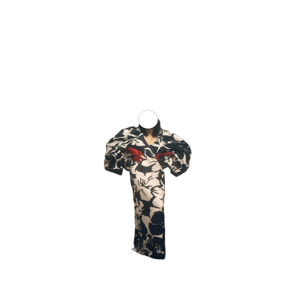

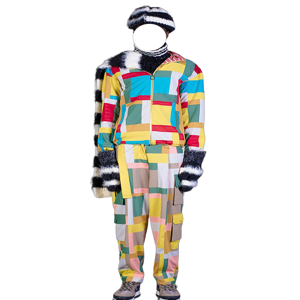

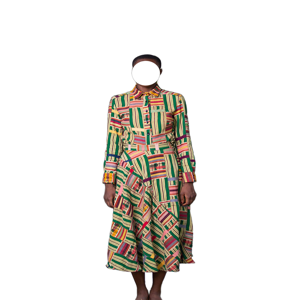

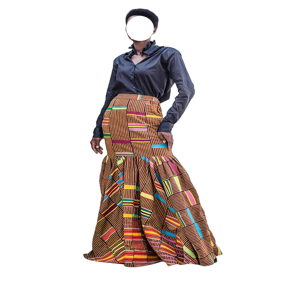

In [22]:
from IPython.display import display, Image
from PIL import Image as PILImage

# 이미지 표시
input_dir = './data/training_image_rembg_anormal'
image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
for path in image_paths:
    img = PILImage.open(path)  # 이미지 열기
    img = img.resize((300, 300))  # 이미지 리사이징 (300x300)
    display(img)  # 이미지 표시

Birefnet이 기존에 Segmentation이 어려웠던 이미지들을 모두 잘 분리한 것을 볼 수 있음.

위의 픽셀 검증 방법으로는 정상적으로 분리되었지만 흰색 픽셀이 많은 경우가 대부분이라 이상하게 처리된 이미지를 완전히 분리할 수 없었음.  
패션 데이터에서 배경 분리는 매우 중요한 요소이므로 오랜 시간이 걸리더라도 훈련셋 전체를 Birefnet으로 분리하기로 결정하였음. 

가용가능한 GPU가 1개 밖에 없어 전처리 시간은 14시간이 소요됨.

In [23]:
import os
import io
import multiprocessing
from rembg import remove, new_session
from PIL import Image
from tqdm import tqdm  # tqdm 모듈 임포트

# 배경 제거 함수
def remove_background(args):
    image_path, output_dir = args  # unpacking 인자
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
    
    # 2. 배경 제거
    model_name = "birefnet-portrait"
    session = new_session(model_name)

    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

# 병렬 처리 함수
def process_images_in_parallel(image_paths, output_dir, num_workers=4):
    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 멀티프로세싱 풀 생성
    pool = multiprocessing.Pool(num_workers)
    
    # tqdm을 사용하여 진행 상황 표시
    # 각 인자를 튜플로 전달
    for _ in tqdm(pool.imap(remove_background, [(image_path, output_dir) for image_path in image_paths]), total=len(image_paths), leave=True, ncols=100):
        pass
    
    # 풀 종료
    pool.close()
    pool.join()

if __name__ == "__main__":
    # 이미지 파일이 들어 있는 디렉토리와 출력 디렉토리 설정
    input_dir = './data/training_image'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/training_image_birefnet'   # 처리된 이미지 저장할 디렉토리
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))][:1]
    
    # 병렬로 이미지 처리
    process_images_in_parallel(image_paths, output_dir, num_workers=4)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.59s/it]


위에서 했던 것과 마찬가지로, 데이터 정합성을 확인하고 결과를 검증해봄.

In [24]:
# 데이터 정합성 확인
training_image_list = get_file_list('data/training_image')
print(len(training_image_list))
rembg_image_list = get_file_list('data/training_image_birefnet')
print(len(training_image_list))

4070
4070


In [25]:
input_dir = './data/training_image'  # 처리할 원본 이미지가 있는 디렉토리
output_dir = './data/training_image_birefnet'   # 처리된 이미지 저장할 디렉토리

# output_dir에서 손상된 파일 리스트 찾기
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")
# 손상된 파일 리스트를 기준으로 input_dir의 파일 경로 리스트 만들기
valid_image_paths = [os.path.join(input_dir, fname) for fname in corrupted_images if os.path.exists(os.path.join(input_dir, fname))]
# # 손상된 파일만 다시 처리
if valid_image_paths:
    process_images_in_parallel(valid_image_paths, output_dir, num_workers=4)


100%|████████████████████████████████████████████████████████| 4070/4070 [00:00<00:00, 23988.13it/s]

손상된 파일 수: 0


Calculating white pixel percentage: 100%|███████████████████████| 4070/4070 [00:48<00:00, 84.72it/s]


image_path  white_pixel_ratio
0     ./data/training_image_birefnet/W_01752_00_metr...           0.789301
1     ./data/training_image_birefnet/W_46417_70_mili...           0.775396
2     ./data/training_image_birefnet/W_01509_00_metr...           0.799774
3     ./data/training_image_birefnet/W_18951_50_femi...           0.597848
4     ./data/training_image_birefnet/W_29485_10_spor...           0.649896
...                                                 ...                ...
4065  ./data/training_image_birefnet/W_03060_50_femi...           0.723210
4066  ./data/training_image_birefnet/W_00032_10_spor...           0.809295
4067  ./data/training_image_birefnet/W_02918_10_spor...           0.810246
4068  ./data/training_image_birefnet/W_08957_19_norm...           0.859291
4069  ./data/training_image_birefnet/W_00465_50_clas...           0.500032

[4070 rows x 2 columns]

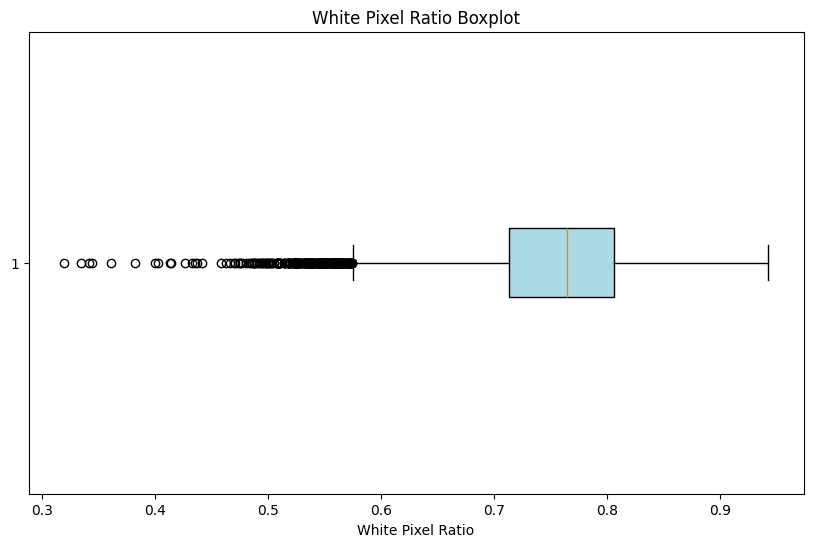

In [27]:
input_dir = './data/training_image_birefnet'  # 처리할 원본 이미지가 있는 디렉토리

# 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

def calculate_white_pixel_percentage_and_path(image_path):
    """
    단일 이미지에서 하얀색 픽셀이 차지하는 비율을 계산하는 함수.
    
    Args:
        image_path (str): 이미지 파일 경로
        
    Returns:
        tuple: 이미지 경로와 하얀색 픽셀 비율
    """
    # 이미지 열기 및 RGB로 변환
    image = Image.open(image_path).convert('RGB')
    
    # 이미지를 NumPy 배열로 변환
    image_np = np.array(image)
    
    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return (image_path, white_ratio)  # 경로와 비율 둘 다 반환

def process_image(image_path):
    """
    multiprocessing에서 사용될 개별 이미지 처리 함수.
    """
    return calculate_white_pixel_percentage_and_path(image_path)

# 병렬로 흰색 픽셀 비율 계산 후 데이터프레임 생성
df = create_white_pixel_dataframe_parallel(image_paths, num_workers=50)

# 데이터프레임 저장 (필요한 경우)
display(df)

# boxplot 그리기
plot_white_pixel_boxplot(df)

흰색 비율이 90% 이상의 이미지를 확인해보고 이상한 이미지가 없는지 확인해보겠다

In [28]:
# 90% 이상의 흰색 픽셀 비율을 가진 이미지 경로 찾기
anomal_train_path = df[df['white_pixel_ratio'] > 0.9]['image_path'].tolist()
anomal_train_path

['./data/training_image_birefnet/W_07271_10_sportivecasual_M.jpg',
 './data/training_image_birefnet/W_05502_00_ecology_W.jpg',
 './data/training_image_birefnet/W_01154_10_athleisure_W.jpg',
 './data/training_image_birefnet/W_07418_50_feminine_W.jpg',
 './data/training_image_birefnet/W_04377_10_sportivecasual_M.jpg',
 './data/training_image_birefnet/W_03849_10_athleisure_W.jpg',
 './data/training_image_birefnet/W_09008_10_sportivecasual_W.jpg',
 './data/training_image_birefnet/W_07785_70_hippie_W.jpg',
 './data/training_image_birefnet/W_09533_90_grunge_W.jpg',
 './data/training_image_birefnet/W_11726_50_feminine_W.jpg',
 './data/training_image_birefnet/W_08691_10_sportivecasual_W.jpg',
 './data/training_image_birefnet/W_07344_10_sportivecasual_M.jpg',
 './data/training_image_birefnet/W_02060_10_athleisure_W.jpg',
 './data/training_image_birefnet/W_02170_50_feminine_W.jpg',
 './data/training_image_birefnet/W_08040_90_kitsch_W.jpg',
 './data/training_image_birefnet/W_05513_60_minimal_W.jp

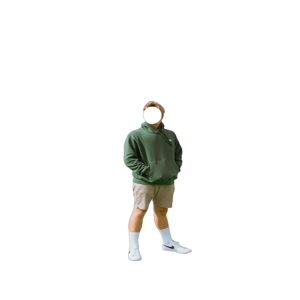

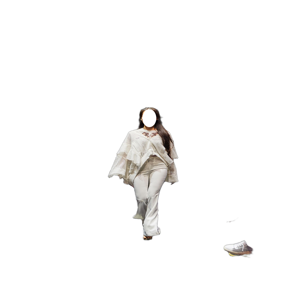

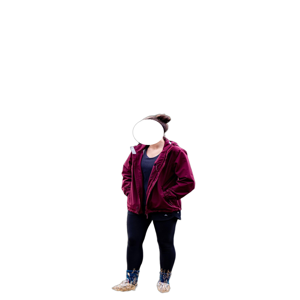

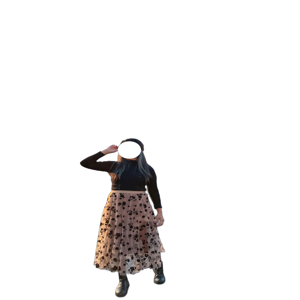

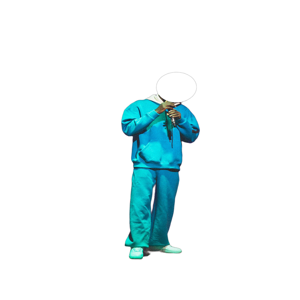

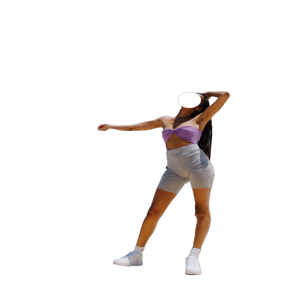

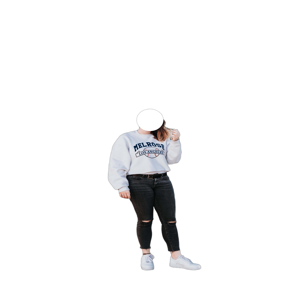

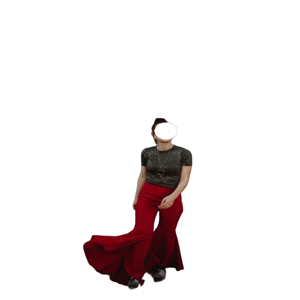

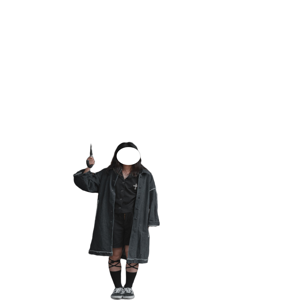

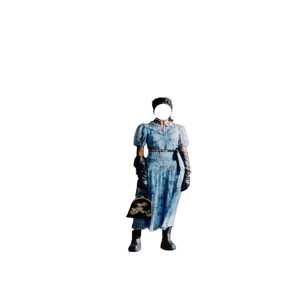

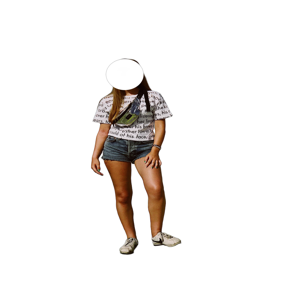

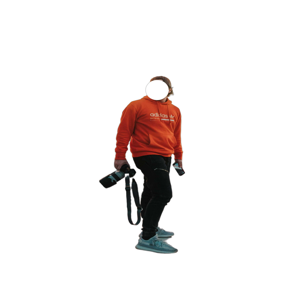

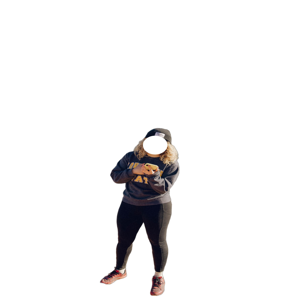

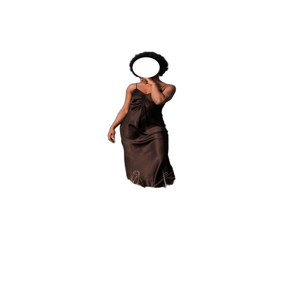

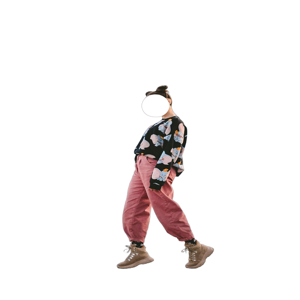

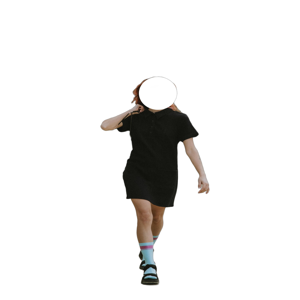

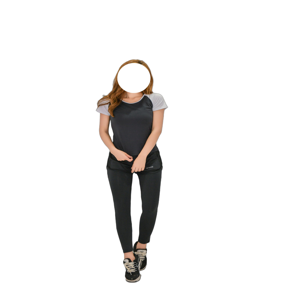

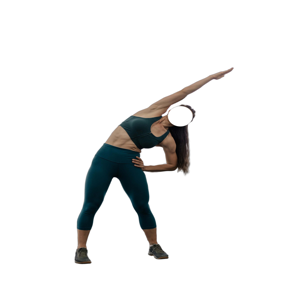

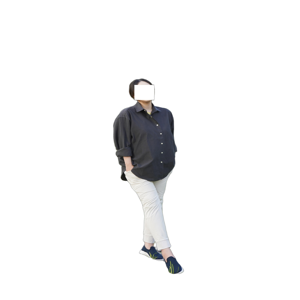

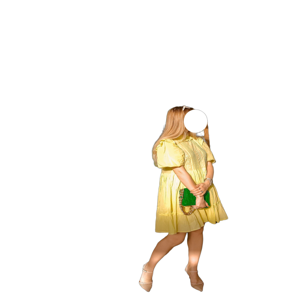

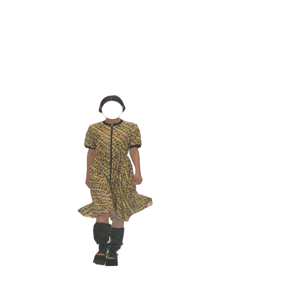

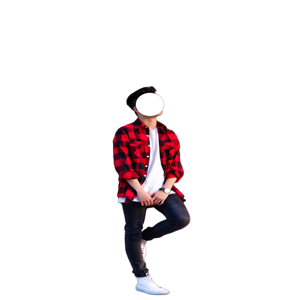

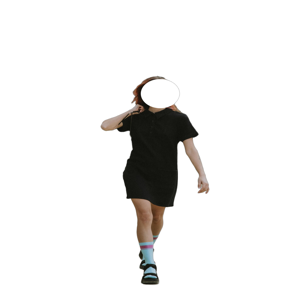

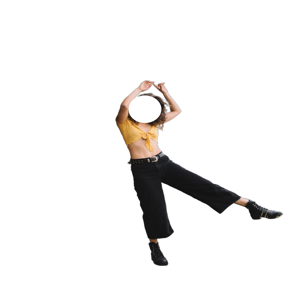

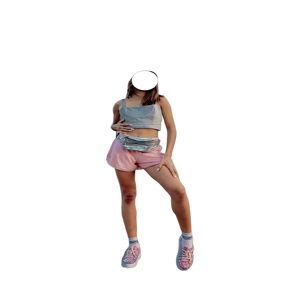

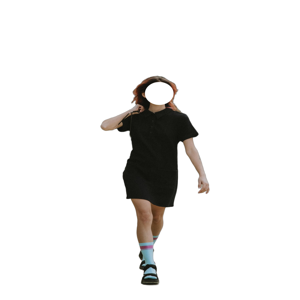

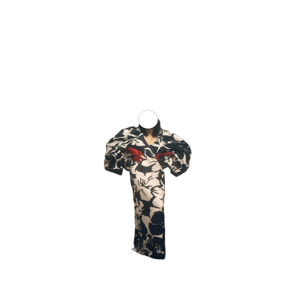

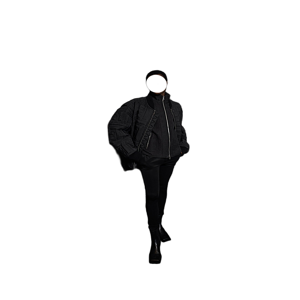

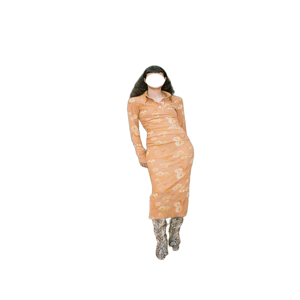

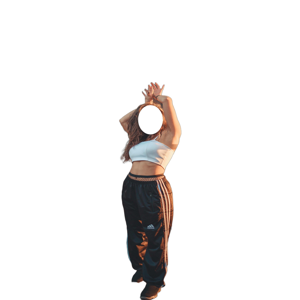

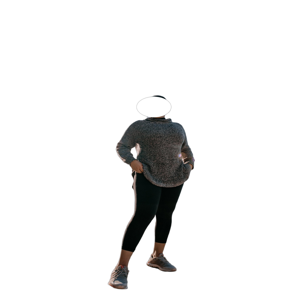

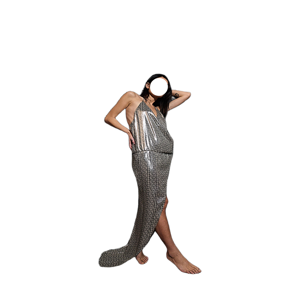

In [29]:
from IPython.display import display
from PIL import Image as PILImage

# 이미지 표시
for path in anomal_train_path:
    img = PILImage.open(path)  # 이미지 열기
    img = img.resize((300, 300))  # 이미지 리사이징 (300x300)
    display(img)  # 이미지 표시

픽셀 검증 방식에서 90% 이상 흰색 배경이라도 모두 오류가 없는 데이터이다. 
이전 U2net 대비 매우 깔끔하게 정리된 이미지들이라고 생각된다.

#### 1-2-1-7.

#### 7) 관심 영역 추출 및 이미지 리사이징

마지막으로 패션이 존재하는 관심영역만을 특정하기 위해 배경만 제거된 이미지에서 인물 영역을 찾아 흰색 배경을 제외한 부분만 잘라내어 저장함.
- 이미지는 이미 배경이 제거되었으므로, CV의 윤곽선 검출을 통해 가장 큰 윤곽선을 감싸는 바운딩 박스를 검출하여 Crop함.
- 이미지의 사이즈가 크므로, Resnet모델에 입력하기 위해 224x224로 사이즈로 리사이징 하는데, 패션이미지 특성상 비율을 맞춰서 패딩을 추가해 리사이징하여 저장함.

In [30]:
import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms.functional as F
from tqdm import tqdm
from multiprocessing import Pool

# 패딩을 통해 원본 패션 이미지의 비율을 지키는 이미지 리사이즈 클래스
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        w, h = img.size
        # 비율 유지하여 리사이즈
        new_h = self.target_size
        new_w = int(self.target_size * (w / h))
        
        img_resized = img.resize((new_w, new_h), Image.LANCZOS)
        
        # 패딩 추가
        if new_w < self.target_size:
            padding = (self.target_size - new_w) // 2
            img_padded = F.pad(img_resized, (padding, 0, padding, 0), fill=255)  # 흰색으로 패딩
        else:
            img_padded = img_resized

        return img_padded

def extract_bounding_box(image_path_and_params):
    image_path, output_dir, target_size = image_path_and_params

    # 이미지 불러오기
    img = cv2.imread(image_path)
    
    # 흰색 배경을 더 정확하게 인식하기 위해 inRange 사용
    lower_white = np.array([200, 200, 200], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    
    # 흰색 배경 제외한 마스크 생성
    mask = cv2.inRange(img, lower_white, upper_white)
    mask_inv = cv2.bitwise_not(mask)  # 흰색 배경 제외한 부분만 남김
    
    # 바운딩 박스 좌표 계산
    contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print(f"인물 영역을 찾지 못했습니다: {image_path}")
        return
    
    # 여러 개의 바운딩 박스를 처리하기 위해 모든 컨투어에서 가장 큰 사각형 찾기
    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    
    # 원본 이미지에서 해당 바운딩 박스 영역만 crop
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # OpenCV 이미지를 PIL 이미지로 변환
    pil_cropped_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    
    # 리사이즈 및 패딩 적용
    resizer = ResizeAndPad(target_size)
    final_img = resizer(pil_cropped_img)
    
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 잘라낸 이미지 저장 경로 설정
    img_name = os.path.basename(image_path).split('.')[0]
    output_path = os.path.join(output_dir, f"{img_name}.jpg")
    
    # 잘라낸 이미지 저장
    final_img.save(output_path)

if __name__ == "__main__":
    input_dir = './data/training_image_birefnet'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/training_image_cropped'  # 잘라낸 이미지 저장 디렉토리
    target_size = 224  # 원하는 크기 224x224)
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 입력 데이터 준비
    params = [(image_path, output_dir, target_size) for image_path in image_paths]
    
    # 모든 이미지에서 인물 부분만 잘라내기 및 리사이즈 (병렬 처리)
    with Pool(10) as pool:
        list(tqdm(pool.imap(extract_bounding_box, params), total=len(params), ncols=100, leave=True))


100%|███████████████████████████████████████████████████████████| 4070/4070 [00:43<00:00, 92.74it/s]


최종 전처리된 이미지는 다음과 같고, 224x224로 다운사이징 되었지만 비율을 지키며 모든 피사체가 중앙에 위치하도록 전처리되었음.

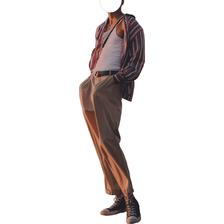

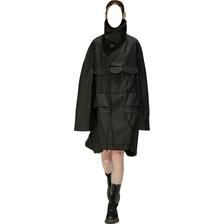

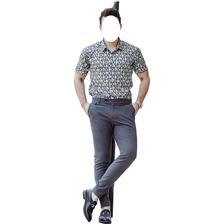

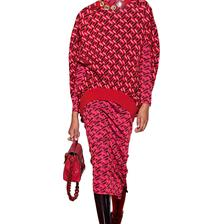

In [31]:
from IPython.display import display
from PIL import Image as PILImage

# 이미지 표시
input_dir = './data/training_image_cropped'
image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))][:4]
for path in image_paths:
    img = PILImage.open(path)  # 이미지 열기
    display(img)  # 이미지 표시

#### 1-2-1-8.

#### 8) validation set 동일 전처리

위 과정을 모두 Validation Image에도 적용해줌.

In [32]:
import os
import io
import multiprocessing
from rembg import remove, new_session
from PIL import Image
from tqdm import tqdm  # tqdm 모듈 임포트

# 배경 제거 함수
def remove_background(args):
    image_path, output_dir = args  # unpacking 인자
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
    
    # 2. 배경 제거
    model_name = "birefnet-portrait"
    session = new_session(model_name)

    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

# 병렬 처리 함수
def process_images_in_parallel(image_paths, output_dir, num_workers=4):
    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 멀티프로세싱 풀 생성
    pool = multiprocessing.Pool(num_workers)
    
    # tqdm을 사용하여 진행 상황 표시
    # 각 인자를 튜플로 전달
    for _ in tqdm(pool.imap(remove_background, [(image_path, output_dir) for image_path in image_paths]), total=len(image_paths), leave=True, ncols=100):
        pass
    
    # 풀 종료
    pool.close()
    pool.join()

if __name__ == "__main__":
    # 이미지 파일이 들어 있는 디렉토리와 출력 디렉토리 설정
    input_dir = './data/validation_image'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/validation_image_birefnet'   # 처리된 이미지 저장할 디렉토리
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))][:1]
    
    # 병렬로 이미지 처리
    process_images_in_parallel(image_paths, output_dir, num_workers=4)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.05s/it]


In [33]:
input_dir = './data/validation_image'  # 처리할 원본 이미지가 있는 디렉토리
output_dir = './data/validation_image_birefnet'   # 처리된 이미지 저장할 디렉토리

# output_dir에서 손상된 파일 리스트 찾기
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")
# 손상된 파일 리스트를 기준으로 input_dir의 파일 경로 리스트 만들기
valid_image_paths = [os.path.join(input_dir, fname) for fname in corrupted_images if os.path.exists(os.path.join(input_dir, fname))]
# # 손상된 파일만 다시 처리
if valid_image_paths:
    process_images_in_parallel(valid_image_paths, output_dir, num_workers=4)

100%|██████████████████████████████████████████████████████████| 951/951 [00:00<00:00, 13891.91it/s]

손상된 파일 수: 0


In [34]:
import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms.functional as F
from tqdm import tqdm
from multiprocessing import Pool

# 패딩을 통해 원본 패션 이미지의 비율을 지키는 이미지 리사이즈 클래스
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        w, h = img.size
        # 비율 유지하여 리사이즈
        new_h = self.target_size
        new_w = int(self.target_size * (w / h))
        
        img_resized = img.resize((new_w, new_h), Image.LANCZOS)
        
        # 패딩 추가
        if new_w < self.target_size:
            padding = (self.target_size - new_w) // 2
            img_padded = F.pad(img_resized, (padding, 0, padding, 0), fill=255)  # 흰색으로 패딩
        else:
            img_padded = img_resized

        return img_padded

def extract_bounding_box(image_path_and_params):
    image_path, output_dir, target_size = image_path_and_params

    # 이미지 불러오기
    img = cv2.imread(image_path)
    
    # 흰색 배경을 더 정확하게 인식하기 위해 inRange 사용
    lower_white = np.array([200, 200, 200], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    
    # 흰색 배경 제외한 마스크 생성
    mask = cv2.inRange(img, lower_white, upper_white)
    mask_inv = cv2.bitwise_not(mask)  # 흰색 배경 제외한 부분만 남김
    
    # 바운딩 박스 좌표 계산
    contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print(f"인물 영역을 찾지 못했습니다: {image_path}")
        return
    
    # 여러 개의 바운딩 박스를 처리하기 위해 모든 컨투어에서 가장 큰 사각형 찾기
    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    
    # 원본 이미지에서 해당 바운딩 박스 영역만 crop
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # OpenCV 이미지를 PIL 이미지로 변환
    pil_cropped_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    
    # 리사이즈 및 패딩 적용
    resizer = ResizeAndPad(target_size)
    final_img = resizer(pil_cropped_img)
    
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 잘라낸 이미지 저장 경로 설정
    img_name = os.path.basename(image_path).split('.')[0]
    output_path = os.path.join(output_dir, f"{img_name}.jpg")
    
    # 잘라낸 이미지 저장
    final_img.save(output_path)

if __name__ == "__main__":
    input_dir = './data/validation_image_birefnet'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/validation_image_cropped'  # 잘라낸 이미지 저장 디렉토리
    target_size = 224  # 원하는 크기 224x224)
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 입력 데이터 준비
    params = [(image_path, output_dir, target_size) for image_path in image_paths]
    
    # 모든 이미지에서 인물 부분만 잘라내기 및 리사이즈 (병렬 처리)
    with Pool(10) as pool:
        list(tqdm(pool.imap(extract_bounding_box, params), total=len(params), ncols=100, leave=True))

100%|█████████████████████████████████████████████████████████████| 951/951 [00:10<00:00, 90.95it/s]


Validation Set이므로 일반화 성능 검증을 위해 따로 결과에 대해 전처리가 잘 되었는지 여부는 검증하지 않음.

#### 1-2-2. 
#### Pytorch 기반 ResNet-18 이미지 분류 모델

#### 1-2-2-1. 
#### 데이터셋 설계

이제 전처리된 training_image_cropped, validation_image_cropped 이미지들을 Pytorch기반 모델에 로드하고 학습을 위한 데이터셋을 설계함.

커스텀 데이터셋을 설계하여 이미지 이름들로 분류되어 있는 폴더를 불러와 데이터셋으로 로딩할 수 있도록 함.

In [1]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

#이미지 이름으로 분류된 폴더에서 이미지를 불러오는 커스텀 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = self.get_image_labels()

    def get_image_labels(self):
        img_labels = []
        for img_file in os.listdir(self.img_dir):
            label = self.extract_label_from_filename(img_file)
            img_labels.append((img_file, label))
        return img_labels

    def extract_label_from_filename(self, filename):
        label = "_".join(filename.split(".")[0].split("_")[3:]) # 파일명에서 라벨 추출
        return label

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋과 데이터로더 생성
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = CustomImageDataset(img_dir='./data/training_image_cropped', transform=transform)

이후 훈련 시 정규화에 활용될 이미지의 RGB채널별 평균, 표준편차를 구해놓는다

In [37]:
from tqdm import tqdm

# 평균과 표준편차 계산 함수
def calculate_mean_std(dataset):
    mean = 0.0
    std = 0.0
    total_images = len(dataset)
    for img, _ in tqdm(dataset):
        # 이미지의 채널 차원에 대해 계산
        mean += img.mean(dim=[1, 2])  # (C,)
        std += img.std(dim=[1, 2])    # (C,)
        
    mean /= total_images
    std /= total_images
    
    return mean, std

# 평균과 표준편차 계산
mean, std = calculate_mean_std(dataset)
print(f"Mean: {mean}, Standard Deviation: {std}")

100%|██████████| 4070/4070 [07:56<00:00,  8.54it/s]

Mean: tensor([0.8752, 0.8656, 0.8636]), Standard Deviation: tensor([0.2598, 0.2734, 0.2761])


#### 1-2-2-2. 
#### 불균형 클래스 처리

클래스의 분포를 확인함.

In [2]:
from collections import Counter

class_counts = Counter([label for _, label in dataset.img_labels])  # 수정된 부분
total_samples = sum(class_counts.values())
print(f"클래스별 샘플 수: {class_counts}")
print(f"전체 샘플 수: {total_samples}")

# 각 클래스의 비율 계산
class_ratios = {cls: count / total_samples*100 for cls, count in class_counts.items()}

# 비율이 낮은 클래스부터 정렬
minority_classes = dict(sorted(class_ratios.items(), key=lambda x: x[1]))

display(minority_classes)

클래스별 샘플 수: Counter({'normcore_M': 364, 'sportivecasual_M': 298, 'metrosexual_M': 278, 'hiphop_M': 274, 'mods_M': 269, 'bold_M': 268, 'hippie_M': 260, 'ivy_M': 237, 'sportivecasual_W': 157, 'feminine_W': 154, 'normcore_W': 153, 'minimal_W': 139, 'powersuit_W': 120, 'bodyconscious_W': 95, 'kitsch_W': 91, 'hippie_W': 91, 'oriental_W': 78, 'classic_W': 77, 'genderless_W': 77, 'athleisure_W': 67, 'cityglam_W': 67, 'punk_W': 65, 'ecology_W': 64, 'lingerie_W': 55, 'hiphop_W': 48, 'lounge_W': 45, 'popart_W': 41, 'space_W': 37, 'disco_W': 37, 'military_W': 33, 'grunge_W': 31})
전체 샘플 수: 4070


{'grunge_W': 0.7616707616707616,
 'military_W': 0.8108108108108109,
 'space_W': 0.9090909090909091,
 'disco_W': 0.9090909090909091,
 'popart_W': 1.0073710073710074,
 'lounge_W': 1.1056511056511056,
 'hiphop_W': 1.1793611793611793,
 'lingerie_W': 1.3513513513513513,
 'ecology_W': 1.5724815724815724,
 'punk_W': 1.597051597051597,
 'athleisure_W': 1.6461916461916464,
 'cityglam_W': 1.6461916461916464,
 'classic_W': 1.891891891891892,
 'genderless_W': 1.891891891891892,
 'oriental_W': 1.9164619164619165,
 'kitsch_W': 2.235872235872236,
 'hippie_W': 2.235872235872236,
 'bodyconscious_W': 2.334152334152334,
 'powersuit_W': 2.9484029484029484,
 'minimal_W': 3.4152334152334154,
 'normcore_W': 3.7592137592137593,
 'feminine_W': 3.783783783783784,
 'sportivecasual_W': 3.857493857493857,
 'ivy_M': 5.823095823095823,
 'hippie_M': 6.388206388206388,
 'bold_M': 6.5847665847665855,
 'mods_M': 6.6093366093366095,
 'hiphop_M': 6.732186732186732,
 'metrosexual_M': 6.830466830466831,
 'sportivecasual_M':

전체 분포가 1%~7% 대로 다양하게 분포해있으므로, 각 분포별로 증강을 적용해서 클래스 균형을 맞춰줌. 

#### 1-2-2-3. 
#### 데이터 증강

클래스당 최소 2000장 정도가 맞춰지도록 각각의 클래스에 대해 증강할 배율을 계산한다.

In [3]:
max_target = 2000  # 클래스당 최대 샘플 수
additional_samples_needed = {cls: max(0, max_target - count) for cls, count in class_counts.items()}

augmentation_ratios = {}

for cls, num_needed in additional_samples_needed.items():
    # 필요한 샘플 수가 0보다 클 경우에만 증강
    if num_needed > 0:
        current_count = class_counts[cls]  # 현재 클래스의 샘플 수
        augmentations_per_class = round(num_needed / current_count)  # 증강 배율 계산(반올림)
        augmentation_ratios[cls] = augmentations_per_class
        print(f"{cls}: 현재 샘플수: {current_count},  {num_needed}개 추가 샘플 필요, 증강 배율: {augmentations_per_class}")

metrosexual_M: 현재 샘플수: 278,  1722개 추가 샘플 필요, 증강 배율: 6
military_W: 현재 샘플수: 33,  1967개 추가 샘플 필요, 증강 배율: 60
feminine_W: 현재 샘플수: 154,  1846개 추가 샘플 필요, 증강 배율: 12
sportivecasual_M: 현재 샘플수: 298,  1702개 추가 샘플 필요, 증강 배율: 6
hiphop_M: 현재 샘플수: 274,  1726개 추가 샘플 필요, 증강 배율: 6
space_W: 현재 샘플수: 37,  1963개 추가 샘플 필요, 증강 배율: 53
mods_M: 현재 샘플수: 269,  1731개 추가 샘플 필요, 증강 배율: 6
normcore_M: 현재 샘플수: 364,  1636개 추가 샘플 필요, 증강 배율: 4
hippie_M: 현재 샘플수: 260,  1740개 추가 샘플 필요, 증강 배율: 7
sportivecasual_W: 현재 샘플수: 157,  1843개 추가 샘플 필요, 증강 배율: 12
powersuit_W: 현재 샘플수: 120,  1880개 추가 샘플 필요, 증강 배율: 16
normcore_W: 현재 샘플수: 153,  1847개 추가 샘플 필요, 증강 배율: 12
kitsch_W: 현재 샘플수: 91,  1909개 추가 샘플 필요, 증강 배율: 21
ivy_M: 현재 샘플수: 237,  1763개 추가 샘플 필요, 증강 배율: 7
bold_M: 현재 샘플수: 268,  1732개 추가 샘플 필요, 증강 배율: 6
classic_W: 현재 샘플수: 77,  1923개 추가 샘플 필요, 증강 배율: 25
oriental_W: 현재 샘플수: 78,  1922개 추가 샘플 필요, 증강 배율: 25
athleisure_W: 현재 샘플수: 67,  1933개 추가 샘플 필요, 증강 배율: 29
punk_W: 현재 샘플수: 65,  1935개 추가 샘플 필요, 증강 배율: 30
genderless_W: 현재 샘플수: 77,  1923개 추가 

증강은 패션 데이터에 알맞게 수평전환, 원근 변환, 각도, 기울기 변환, 색상 조정, 랜덤 크롭을 수행한다. 

증강으로 패딩이 생기는 부분은 기존 하얀 배경과 통일하기 위해 흰색으로 채운다.

In [4]:
import os
from PIL import Image
from tqdm import tqdm
from multiprocessing import Pool
from torchvision import transforms

# 각 클래스에 따른 증강 전략 설정
def augment_image(args):
    img_file, label, extra_transforms, num_augmentation = args
    img_path = os.path.join(dataset.img_dir, img_file)
    image = Image.open(img_path).convert("RGB")
    
    augmented_data = []

    for _ in range(num_augmentation):  # 증강 배율만큼 반복
        augmented_img = extra_transforms(image)
        augmented_data.append((augmented_img, label))

    return augmented_data

# 소수 클래스에 대해 적용할 추가 증강
additional_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 랜덤 수평 뒤집기
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=(255, 255, 255)),  # 랜덤 원근 변환
    transforms.RandomAffine(degrees=(-20, 20), shear=10, fill=(255, 255, 255)),  # 랜덤 각도, 기울기 변환
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 색상 조정
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.333), interpolation=2),  # 랜덤 크롭 및 리사이즈
    transforms.ToTensor()
])

def save_augmented_images(augmented_data, output_dir):
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, (img_tensor, label) in enumerate(augmented_data):
        # 텐서를 PIL 이미지로 변환
        img = transforms.ToPILImage()(img_tensor)
        # 저장할 파일 이름 설정
        img_filename = f"Preprocess_Augmented_{i}_{label}.jpg"
        img_path = os.path.join(output_dir, img_filename)
        img.save(img_path)


# 병렬 처리 설정
if __name__ == '__main__':
    # dataset_args = [(img_file, label, additional_transforms) for img_file, label in dataset.img_labels]
    dataset_args = [
        (img_file, label, additional_transforms, augmentation_ratios[label])
        for img_file, label in dataset.img_labels if augmentation_ratios[label] > 0
    ]

    augmented_data = []
    with Pool(processes=20) as pool:
        for result in tqdm(pool.imap(augment_image, dataset_args), total=len(dataset_args), desc="Augmenting Images", ncols=100, leave=True):
            augmented_data.extend(result)
    
    output_dir = './data/training_image_augmented'
    save_augmented_images(augmented_data, output_dir)

Augmenting Images: 100%|████████████████████████████████████████| 4070/4070 [58:41<00:00,  1.16it/s]


증강한 데이터를 불러와서 제대로 적용되었는지 살펴보았음.

In [9]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

#이미지 이름으로 분류된 폴더에서 이미지를 불러오는 훈련용 데이터셋 클래스
class TrainingImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, label_encoder=None, is_training=False):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = self.get_image_labels()
        self.is_training = is_training
        
        if self.is_training:
            # 훈련 데이터에서는 LabelEncoder 사용
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform([label for _, label in self.img_labels])
        else:
            # 평가/테스트 모드에서는 인코딩 없이 원래 레이블을 유지
            self.labels = [label for _, label in self.img_labels]

    def get_image_labels(self):
        img_labels = []
        for img_file in os.listdir(self.img_dir):
            label = self.extract_label_from_filename(img_file)
            img_labels.append((img_file, label))
        return img_labels

    def extract_label_from_filename(self, filename):
        label = "_".join(filename.split(".")[0].split("_")[3:]) # Extract label from filename
        return label

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if self.is_training:
            img_name = self.img_labels[idx][0]
            label = self.labels[idx]
        else:
            img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋과 데이터로더 생성
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = TrainingImageDataset(img_dir='./data/training_image_cropped', transform=transform)
dataset_augmented = TrainingImageDataset(img_dir='./data/training_image_augmented', transform=transform)

# 두 데이터셋을 합치기
from torch.utils.data import ConcatDataset

class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)
        self.labels = []
        for dataset in datasets:
            self.labels.extend(dataset.labels)

concat_dataset = CustomConcatDataset([dataset, dataset_augmented])

증강이 잘 적용된것을 볼 수 있음.

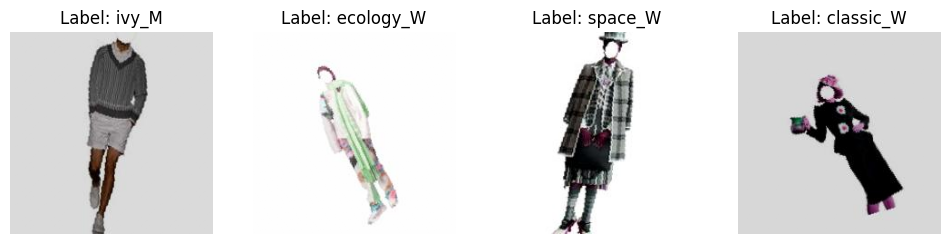

In [13]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# DataLoader를 사용하여 배치로 데이터 가져오기
data_loader = DataLoader(concat_dataset, batch_size=4, shuffle=True)

# 배치에서 이미지와 레이블 가져오기
images, labels = next(iter(data_loader))

# 이미지 시각화
def show_images(images, labels):
    # 이미지 수에 따라 서브플롯 크기 설정
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

show_images(images, labels)

증강 수치는 4,070장에서 61582장으로 약 15배 가량 증폭되었음.

클래스별 샘플 수 도 비슷해진 것을 볼 수 있음.

In [14]:
from collections import Counter

# 클래스 카운트
class_counts = Counter([label for label in concat_dataset.labels])
total_samples = sum(class_counts.values())

# 결과 정렬
sorted_class_counts = class_counts.most_common()
num_classes = len(class_counts)
# 결과 출력
print(f"전체 샘플 수: {total_samples}")
print(f"클래스 개수: {num_classes}")
print(f"클래스별 샘플 수:{sorted_class_counts}")


전체 샘플 수: 61582
클래스 개수: 31
클래스별 샘플 수:[('sportivecasual_M', 2086), ('hippie_M', 2080), ('sportivecasual_W', 2041), ('powersuit_W', 2040), ('oriental_W', 2028), ('hiphop_W', 2016), ('punk_W', 2015), ('grunge_W', 2015), ('military_W', 2013), ('athleisure_W', 2010), ('cityglam_W', 2010), ('popart_W', 2009), ('feminine_W', 2002), ('kitsch_W', 2002), ('classic_W', 2002), ('genderless_W', 2002), ('hippie_W', 2002), ('space_W', 1998), ('disco_W', 1998), ('bodyconscious_W', 1995), ('normcore_W', 1989), ('ecology_W', 1984), ('lounge_W', 1980), ('lingerie_W', 1980), ('metrosexual_M', 1946), ('minimal_W', 1946), ('hiphop_M', 1918), ('ivy_M', 1896), ('mods_M', 1883), ('bold_M', 1876), ('normcore_M', 1820)]


#### 1-2-2-4. 
#### Baseline Training

소량의 데이터로 증강을 많이 하면 과적합 우려가 있어 데이터 로더에 WeightedRandomSampler를 적용하여, 소수 클래스가 균형적으로 학습될 수 있도록 데이터 샘플링 확률을 조정함.

훈련용 데이터셋 로딩 시, 각 샘플 수를 1로 나눠 취한 역수로 구한 가중치를 데이터 로더에 주어 더 적은 샘플로 이루어진 데이터가 학습 시, 더 많이 노출되도록 함.

또한 학습을 위해 클래스 정보를 라벨인코딩하여 숫자로 바꿔 모델이 예측할 수 있게함.

처음에는 먼저 증강되지 않은 데이터로 베이스라인 훈련을 돌려봄.

In [23]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# 클래스 카운트
class_counts = Counter([label for label in dataset.labels])
total_samples = sum(class_counts.values())

# 결과 정렬
sorted_class_counts = class_counts.most_common()
num_classes = len(class_counts)
# 결과 출력
print(f"전체 샘플 수: {total_samples}")
print(f"클래스 개수: {num_classes}")
print(f"클래스별 샘플 수:{sorted_class_counts}")

weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [weights[label] for label in dataset.labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit([label for label in concat_dataset.labels])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # 계산해놨던 평균 및 표준편차를 사용하여 정규화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8752, 0.8656, 0.8636], std=[0.2598, 0.2734, 0.2761])
])

train_dataset = TrainingImageDataset(img_dir='./data/training_image_cropped', transform=transform, label_encoder=label_encoder, is_training=True)

train_loader = DataLoader(train_dataset, batch_size=256, sampler=sampler, num_workers=8)

val_dataset = TrainingImageDataset(img_dir='./data/validation_image_cropped', transform=transform, label_encoder=label_encoder, is_training=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)

전체 샘플 수: 4070
클래스 개수: 31
클래스별 샘플 수:[('normcore_M', 364), ('sportivecasual_M', 298), ('metrosexual_M', 278), ('hiphop_M', 274), ('mods_M', 269), ('bold_M', 268), ('hippie_M', 260), ('ivy_M', 237), ('sportivecasual_W', 157), ('feminine_W', 154), ('normcore_W', 153), ('minimal_W', 139), ('powersuit_W', 120), ('bodyconscious_W', 95), ('kitsch_W', 91), ('hippie_W', 91), ('oriental_W', 78), ('classic_W', 77), ('genderless_W', 77), ('athleisure_W', 67), ('cityglam_W', 67), ('punk_W', 65), ('ecology_W', 64), ('lingerie_W', 55), ('hiphop_W', 48), ('lounge_W', 45), ('popart_W', 41), ('space_W', 37), ('disco_W', 37), ('military_W', 33), ('grunge_W', 31)]


모델 구조는 Pytorch에 구현되어 있는 기본 ResNet-18 구조를 불러왔고, 사전 가중치는 미션 제약에 따라 불러오지 않음.  

resnet에서 나온 특성 데이터를 이용해 분류를 진행할 FC레이어에 추론할 클래스 갯수를 적용한다.

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models
import time

# ResNet18 모델 초기화 (사전 가중치 사용 안 함)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))  # 마지막 레이어 변경

num_total_params = sum(p.numel() for p in model.parameters())
print("총 파라미터 갯수 : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
gpu_name = torch.cuda.get_device_name(device)
print(f"사용 중인 GPU: {gpu_name}")

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    return correct / len(preds) * 100

# 모델 훈련 함수
def train_model(model, criterion, optimizer, num_epochs=150):
    print("Training started...")
    start = time.time()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    model.train()
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_acc = 0.0
        running_test_loss = 0.0
        running_test_acc = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_acc += accuracy(outputs, labels)
        train_loss.append(running_train_loss / len(train_loader))
        train_acc.append(running_train_acc / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                running_test_acc += accuracy(outputs, labels)
            test_loss.append(running_test_loss / len(val_loader))
            test_acc.append(running_test_acc / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.2f}%")
        
    end = time.time()
    minute = (end-start)//60
    print(f"Training time: {minute}m {end-start-minute*60:.2f}s")
    return train_loss, train_acc, test_loss, test_acc, model

train_loss, train_acc, test_loss, test_acc, model = train_model(model, criterion, optimizer, num_epochs=50)

총 파라미터 갯수 :  11192415
사용 중인 GPU: NVIDIA RTX A5000
Training started...
Epoch 1/50, Train Loss: 3.3473, Train Acc: 8.73%, Test Loss: 3.5928, Test Acc: 3.06%
Epoch 2/50, Train Loss: 3.8766, Train Acc: 3.45%, Test Loss: 3.4332, Test Acc: 2.93%
Epoch 3/50, Train Loss: 3.4326, Train Acc: 4.90%, Test Loss: 3.4360, Test Acc: 3.16%
Epoch 4/50, Train Loss: 3.4233, Train Acc: 5.22%, Test Loss: 3.4546, Test Acc: 1.76%
Epoch 5/50, Train Loss: 3.4237, Train Acc: 4.19%, Test Loss: 3.4421, Test Acc: 2.64%
Epoch 6/50, Train Loss: 3.4121, Train Acc: 4.34%, Test Loss: 3.4082, Test Acc: 2.28%
Epoch 7/50, Train Loss: 3.4010, Train Acc: 5.02%, Test Loss: 3.4127, Test Acc: 7.19%
Epoch 8/50, Train Loss: 3.3979, Train Acc: 4.90%, Test Loss: 3.4227, Test Acc: 5.92%
Epoch 9/50, Train Loss: 3.3957, Train Acc: 5.07%, Test Loss: 3.3947, Test Acc: 6.67%
Epoch 10/50, Train Loss: 3.3939, Train Acc: 4.91%, Test Loss: 3.4633, Test Acc: 1.66%
Epoch 11/50, Train Loss: 3.3922, Train Acc: 6.04%, Test Loss: 3.3740, Test Acc:

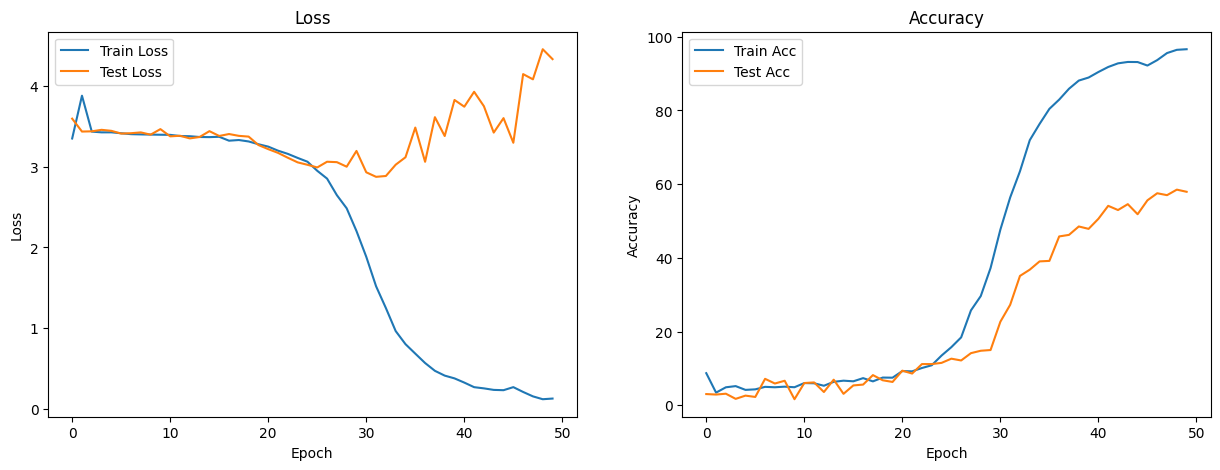

In [26]:
import matplotlib.pyplot as plt

def display_graph(train_loss, train_acc, test_loss, test_acc):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(test_loss, label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='Train Acc')
    ax[1].plot(test_acc, label='Test Acc')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()
    
display_graph(train_loss, train_acc, test_loss, test_acc)

#### 1-2-2-5.
#### Augmentation Data Training

다음은 이를 모두 합치고 증강된 데이터로 훈련하는 코드이다.

랜덤성을 제어하기 위해 시드를 고정하고, 모델 초기 가중치 초기화 방식을 relu에 유리한 He 초기화 (Kaiming Initialization) : 입력 노드 수에 따라 가중치를 초기화

방식을 적용하였다.


In [1]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

import random
import numpy as np
import torch

# 랜덤 시드 값
seed = 42

# 파이썬의 랜덤 모듈
random.seed(seed)

# 넘파이 랜덤 모듈
np.random.seed(seed)

# 토치 랜덤 모듈
torch.manual_seed(seed)

# CUDA를 사용하는 경우
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

#이미지 이름으로 분류된 폴더에서 이미지를 불러오는 훈련용 데이터셋 클래스
class TrainingImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, label_encoder=None, is_training=False):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = self.get_image_labels()
        self.is_training = is_training
        
        if self.is_training:
            # 훈련 데이터에서는 LabelEncoder 사용
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform([label for _, label in self.img_labels])
        else:
            # 평가/테스트 모드에서는 인코딩 없이 원래 레이블을 유지
            self.labels = [label for _, label in self.img_labels]

    def get_image_labels(self):
        img_labels = []
        for img_file in os.listdir(self.img_dir):
            label = self.extract_label_from_filename(img_file)
            img_labels.append((img_file, label))
        return img_labels

    def extract_label_from_filename(self, filename):
        label = "_".join(filename.split(".")[0].split("_")[3:]) # Extract label from filename
        return label

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if self.is_training:
            img_name = self.img_labels[idx][0]
            label = self.labels[idx]
        else:
            img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋과 데이터로더 생성
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8752, 0.8656, 0.8636], std=[0.2598, 0.2734, 0.2761])
])

dataset = TrainingImageDataset(img_dir='./data/training_image_cropped', transform=transform)
dataset_augmented = TrainingImageDataset(img_dir='./data/training_image_augmented', transform=transform)

# 두 데이터셋을 합치기
from torch.utils.data import ConcatDataset

class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)
        self.labels = []
        for dataset in datasets:
            self.labels.extend(dataset.labels)

concat_dataset = CustomConcatDataset([dataset, dataset_augmented])

from collections import Counter

# 클래스 카운트
class_counts = Counter([label for label in concat_dataset.labels])
total_samples = sum(class_counts.values())

# 결과 정렬
sorted_class_counts = class_counts.most_common()
num_classes = len(class_counts)
# 결과 출력
print(f"전체 샘플 수: {total_samples}")
print(f"클래스 개수: {num_classes}")
print(f"클래스별 샘플 수:{sorted_class_counts}")

from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder

weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [weights[label] for label in concat_dataset.labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 각 클래스별 예상 배율 출력
total_weight = sum(sample_weights)  # 전체 가중치의 합
class_ratios = {cls: (weights[cls] * len(sample_weights)) / total_weight for cls in class_counts.keys()}  # 각 클래스별 배율 계산

print("각 클래스별 적용된 노출 예상 배율:")
print(class_ratios)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit([label for label in concat_dataset.labels])

dataset = TrainingImageDataset(img_dir='./data/training_image_cropped', transform=transform, label_encoder=label_encoder, is_training=True)
dataset_augmented = TrainingImageDataset(img_dir='./data/training_image_augmented', transform=transform, label_encoder=label_encoder, is_training=True)

train_dataset = CustomConcatDataset([dataset, dataset_augmented])
train_loader = DataLoader(train_dataset, batch_size=256, sampler=sampler, num_workers=8)

val_dataset = TrainingImageDataset(img_dir='./data/validation_image_cropped', transform=transform, label_encoder=label_encoder, is_training=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)

print("훈련 이미지 갯수 : ", len(train_dataset))
print("검증 이미지 갯수 : ", len(val_dataset))
print("클래스 갯수 : ", len(label_encoder.classes_))

전체 샘플 수: 61582
클래스 개수: 31
클래스별 샘플 수:[('sportivecasual_M', 2086), ('hippie_M', 2080), ('sportivecasual_W', 2041), ('powersuit_W', 2040), ('oriental_W', 2028), ('hiphop_W', 2016), ('punk_W', 2015), ('grunge_W', 2015), ('military_W', 2013), ('athleisure_W', 2010), ('cityglam_W', 2010), ('popart_W', 2009), ('feminine_W', 2002), ('kitsch_W', 2002), ('classic_W', 2002), ('genderless_W', 2002), ('hippie_W', 2002), ('space_W', 1998), ('disco_W', 1998), ('bodyconscious_W', 1995), ('normcore_W', 1989), ('ecology_W', 1984), ('lounge_W', 1980), ('lingerie_W', 1980), ('metrosexual_M', 1946), ('minimal_W', 1946), ('hiphop_M', 1918), ('ivy_M', 1896), ('mods_M', 1883), ('bold_M', 1876), ('normcore_M', 1820)]
각 클래스별 적용된 노출 예상 배율:
{'metrosexual_M': 1.0208202101912842, 'military_W': 0.986843581238072, 'feminine_W': 0.9922657987174021, 'sportivecasual_M': 0.9523087866885133, 'hiphop_M': 1.035722695011595, 'space_W': 0.9942523168329525, 'mods_M': 1.0549740462199888, 'normcore_M': 1.0914923785891424, 'hippi

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import time
import os

# 체크포인트 저장 함수
def save_checkpoint(model, optimizer, epoch, loss, acc, filename='model/checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': acc,
    }, filename)

# 체크포인트 로딩 함수
def load_checkpoint(model, optimizer, filename='model/checkpoint.pth'):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        return start_epoch, checkpoint['loss'], checkpoint['accuracy']
    else:
        print(f"No checkpoint found at '{filename}'")
        return 0, None, None


# ResNet18 모델 초기화 (사전 가중치 사용 안 함)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))  # 마지막 레이어 변경

# kaiming_uniform 초기화 함수 적용
def weights_init_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(weights_init_he)

num_total_params = sum(p.numel() for p in model.parameters())
print("총 파라미터 갯수 : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
gpu_name = torch.cuda.get_device_name(device)
print(f"사용 중인 GPU: {gpu_name}")

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    return correct / len(preds) * 100

# 모델 훈련 함수
def train_model(model, criterion, optimizer, num_epochs=50, checkpoint_path='model/checkpoint.pth'):
    print("Training started...")
    start = time.time()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # 체크포인트 로딩
    start_epoch, _, best_acc = load_checkpoint(model, optimizer, checkpoint_path)
    best_acc = best_acc if best_acc is not None else 0  # 초기 최적의 정확도 설정

    model.train()
    
    for epoch in range(start_epoch, num_epochs):
        running_train_loss = 0.0
        running_train_acc = 0.0
        running_test_loss = 0.0
        running_test_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_acc += accuracy(outputs, labels)

        train_loss.append(running_train_loss / len(train_loader))
        train_acc.append(running_train_acc / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                running_test_acc += accuracy(outputs, labels)
            test_loss.append(running_test_loss / len(val_loader))
            test_acc.append(running_test_acc / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.2f}%")
        
        # 이전 체크포인트 삭제하고, 성능이 개선될 경우 체크포인트 저장
        current_acc = test_acc[-1]
        if current_acc > best_acc:
            best_acc = current_acc
            if os.path.exists(checkpoint_path):
                os.remove(checkpoint_path)  # 이전 체크포인트 삭제
            save_checkpoint(model, optimizer, epoch + 1, train_loss[-1], train_acc[-1], checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch + 1}")
        
    end = time.time()
    minute = (end - start) // 60
    print(f"Training time: {minute}m {end - start - minute * 60:.2f}s")
    return train_loss, train_acc, test_loss, test_acc, model

# 모델 훈련 시작
train_loss, train_acc, test_loss, test_acc, model = train_model(model, criterion, optimizer, num_epochs=50)


총 파라미터 갯수 :  11192415
사용 중인 GPU: NVIDIA RTX A5000
Training started...
No checkpoint found at 'model/checkpoint.pth'
Epoch 1/50, Train Loss: 3.1509, Train Acc: 11.67%, Test Loss: 3.6156, Test Acc: 8.23%
Checkpoint saved at epoch 1
Epoch 2/50, Train Loss: 3.5659, Train Acc: 4.20%, Test Loss: 3.4378, Test Acc: 6.12%
Epoch 3/50, Train Loss: 3.3930, Train Acc: 5.29%, Test Loss: 3.3451, Test Acc: 5.82%
Epoch 4/50, Train Loss: 3.3518, Train Acc: 6.44%, Test Loss: 3.2715, Test Acc: 8.17%
Epoch 5/50, Train Loss: 3.2651, Train Acc: 8.74%, Test Loss: 3.1094, Test Acc: 12.56%
Checkpoint saved at epoch 5
Epoch 6/50, Train Loss: 3.1215, Train Acc: 11.97%, Test Loss: 2.9544, Test Acc: 12.46%
Epoch 7/50, Train Loss: 2.8910, Train Acc: 17.28%, Test Loss: 2.7663, Test Acc: 19.10%
Checkpoint saved at epoch 7
Epoch 8/50, Train Loss: 2.5263, Train Acc: 26.91%, Test Loss: 2.7212, Test Acc: 23.79%
Checkpoint saved at epoch 8
Epoch 9/50, Train Loss: 2.0034, Train Acc: 41.20%, Test Loss: 2.5322, Test Acc: 30.7

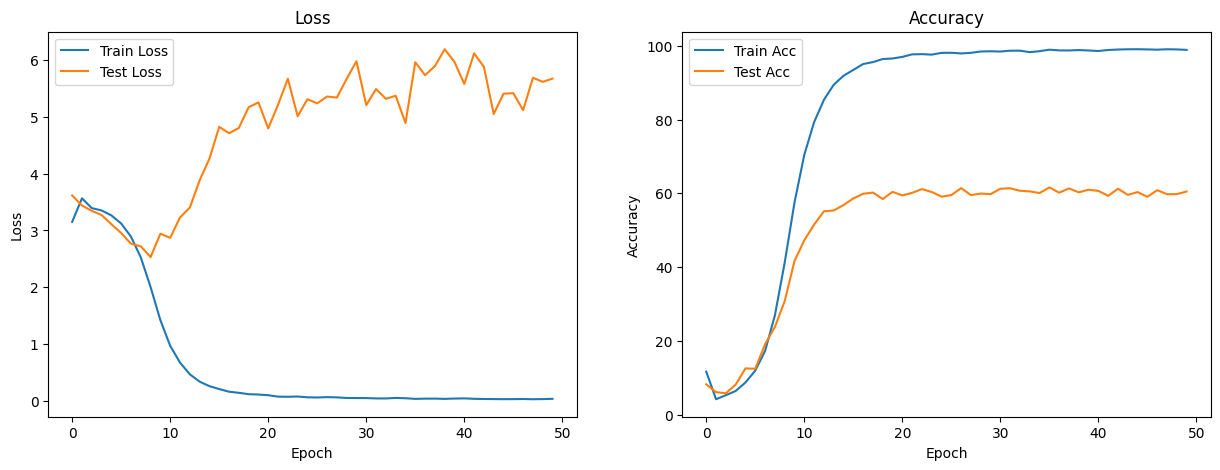

In [3]:
import matplotlib.pyplot as plt

def display_graph(train_loss, train_acc, test_loss, test_acc):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(test_loss, label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='Train Acc')
    ax[1].plot(test_acc, label='Test Acc')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()
    
display_graph(train_loss, train_acc, test_loss, test_acc)

#### 1-2-2-6.
#### Save & Load Model Inference

다음은 최종 정확도를 확인하고 모델의 가중치를 저장하는 코드이다.

In [29]:


import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# 모델 불러오기
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))
model.to(device)
model.load_state_dict(torch.load('model/checkpoint.pth', map_location=device, weights_only=False)['model_state_dict'])

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the val images: {} %'.format(100 * correct / total))
    
    # Save the model pt
    torch.save(model.state_dict(), 'fashion_resnet18.pt')

Test Accuracy of the model on the val images: 61.30389064143007 %


/tmp/ipykernel_1174756/2640461852.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/checkpoint.pth', map_location=device)['model_s

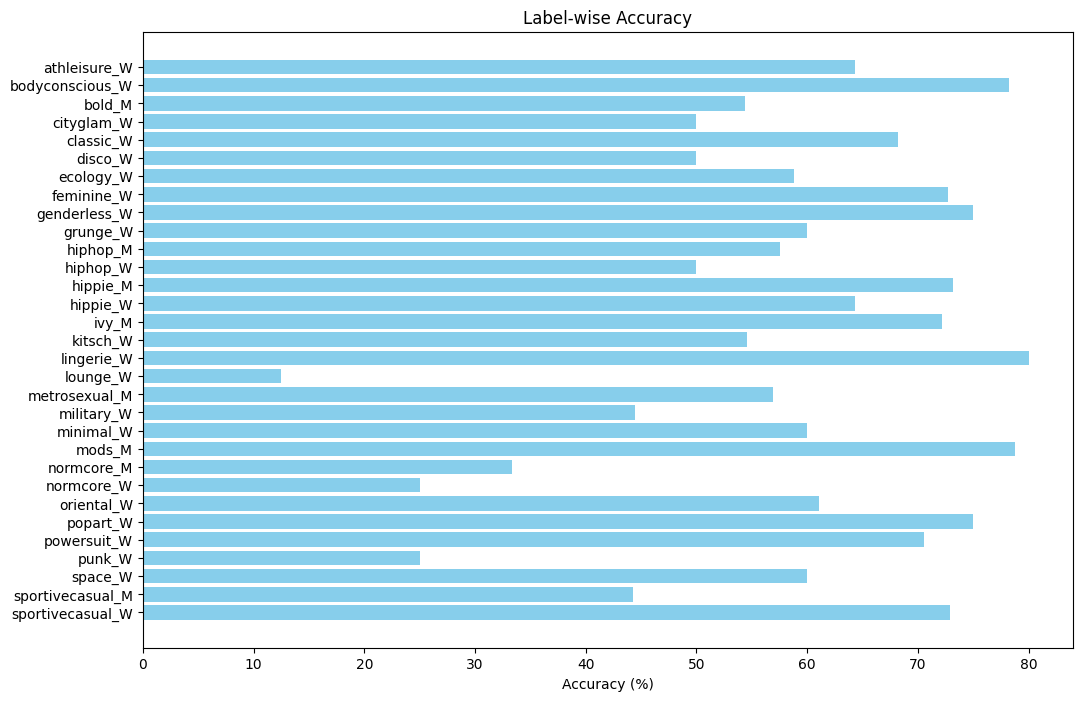

In [63]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

# 모델 불러오기 및 설정
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))
model.to(device)
model.load_state_dict(torch.load('model/checkpoint.pth', map_location=device)['model_state_dict'])

model.eval()

# 라벨별 정확도 계산
class_correct = list(0. for i in range(len(label_encoder.classes_)))
class_total = list(0. for i in range(len(label_encoder.classes_)))

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct_tensor = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct_tensor[i].item()
            class_total[label] += 1

# 라벨별 정확도 계산 및 시각화
accuracy = [100 * (class_correct[i] / class_total[i]) if class_total[i] > 0 else 0 for i in range(len(label_encoder.classes_))]
labels = [label_encoder.classes_[i] for i in range(len(label_encoder.classes_))]

# 그래프 그리기
plt.figure(figsize=(12, 8))
plt.barh(labels, accuracy, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Label-wise Accuracy')
plt.gca().invert_yaxis()  # 가장 높은 정확도가 위로 오게 하기 위해 Y축 반전
plt.show()



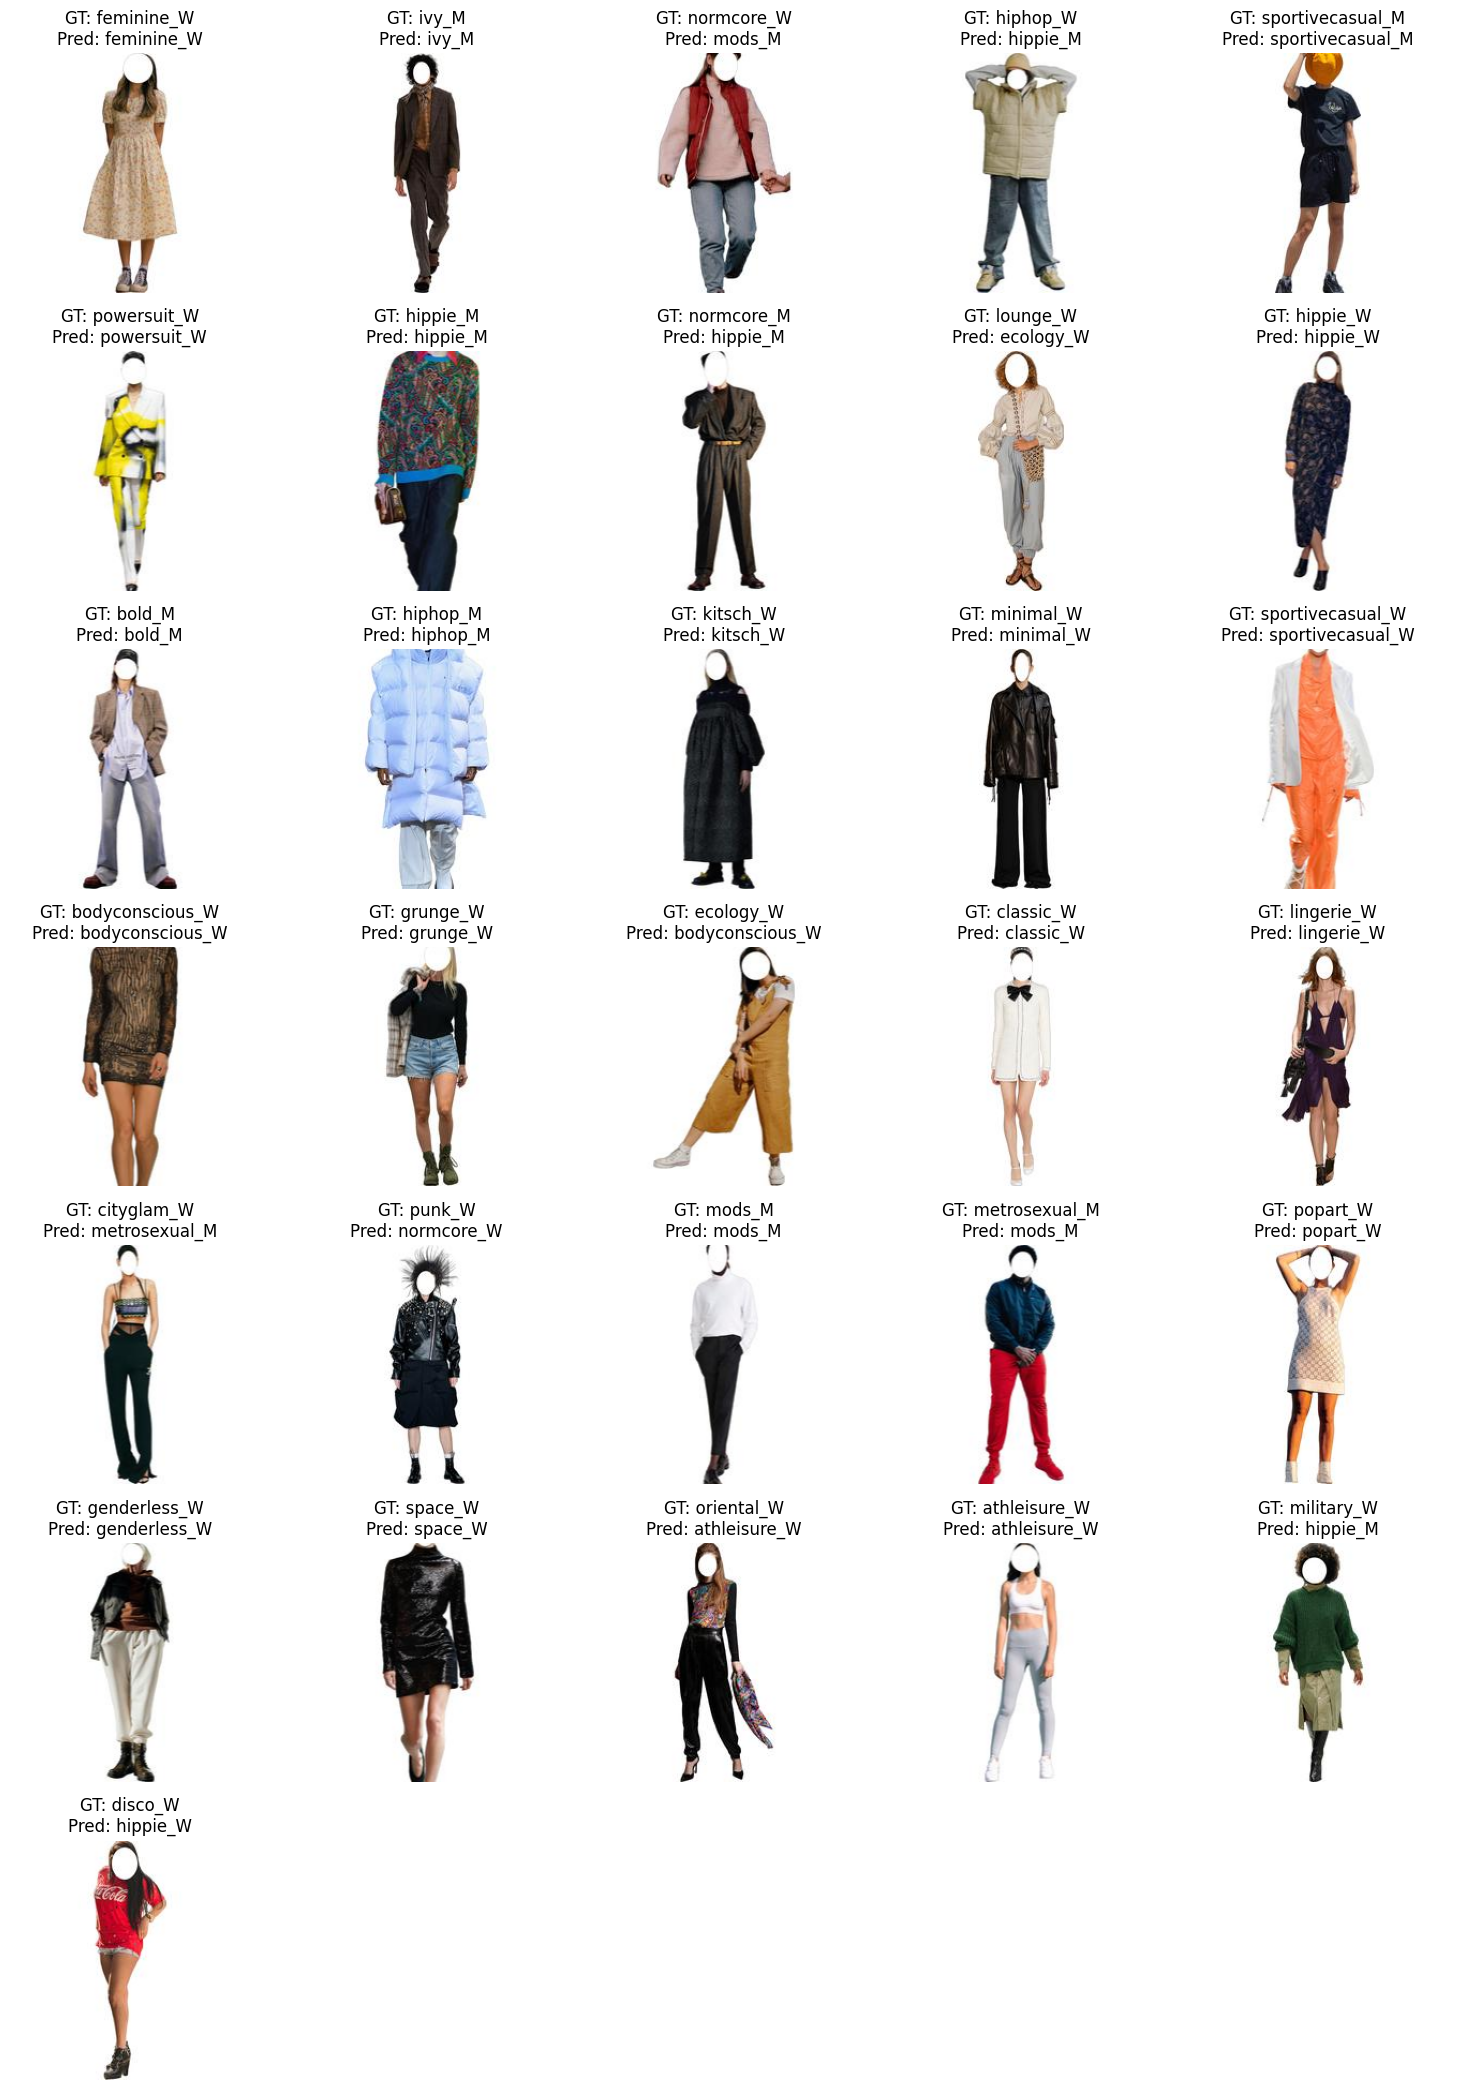

In [64]:
import matplotlib.pyplot as plt
import torchvision
import math

# 정규화 해제 함수 정의
def denormalize(img, mean, std):
    img = img.clone()  # 원본 이미지를 변경하지 않기 위해 복사
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # 역정규화
    return img

# 정규화 해제할 때 사용할 mean과 std 값 정의
mean = [0.8752, 0.8656, 0.8636]  # ImageNet에서 일반적으로 사용하는 평균 값
std = [0.2598, 0.2734, 0.2761]   # ImageNet에서 일반적으로 사용하는 표준 편차 값

# 각 클래스의 첫 번째 예측 결과를 저장할 딕셔너리 초기화
class_images = {}
class_labels = {}

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # 각 클래스별 첫 번째 예측 이미지를 저장
        for img, label, pred in zip(images, labels, predicted):
            if label.item() not in class_images:
                # 역정규화 후 저장
                class_images[label.item()] = denormalize(img.cpu(), mean, std)
                class_labels[label.item()] = pred.cpu()
                
            # 모든 클래스에 대해 이미지가 수집되면 반복 종료
            if len(class_images) == len(label_encoder.classes_):
                break
        if len(class_images) == len(label_encoder.classes_):
            break

# 동적 그리드 크기 계산
num_classes = len(class_images)
cols = int(math.sqrt(num_classes))  # 그리드의 열 개수
rows = math.ceil(num_classes / cols)  # 그리드의 행 개수

# 시각화
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()  # 인덱싱을 쉽게 하기 위해 축을 1차원 배열로 변환

for idx, (label_idx, img) in enumerate(class_images.items()):
    label_name = label_encoder.classes_[label_idx]
    pred_name = label_encoder.classes_[class_labels[label_idx]]
    
    ax = axes[idx]
    img_np = img.permute(1, 2, 0).numpy()  # 이미지를 numpy 형식으로 변환
    img_np = np.clip(img_np, 0, 1)  # 값 범위를 [0, 1]로 제한
    ax.imshow(img_np)
    ax.set_title(f'GT: {label_name}\nPred: {pred_name}')
    ax.axis('off')

# 나머지 빈 축 숨기기
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

마지막으로, 저장한 모델을 다시 불러와 로딩되어있는 Validation 데이터를 이용해 추론 테스트를 진행해본다.

Load PT Model and VISUALIZE THE RESULT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3687453..0.49402383].


Predicted:  oriental_W / ivy_M / bold_M / cityglam_W


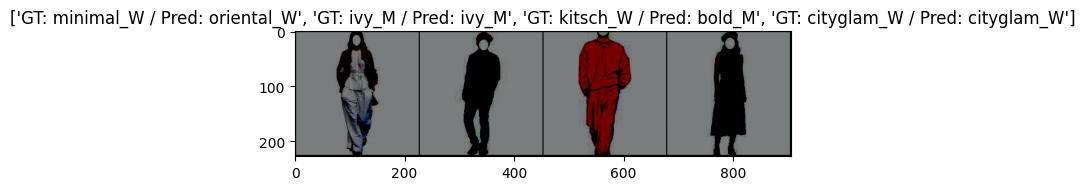

In [62]:
print('Load PT Model and VISUALIZE THE RESULT')


loaded_model = models.resnet18(weights=None)
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, len(label_encoder.classes_))
loaded_model.to(device)
loaded_model.load_state_dict(torch.load('fashion_resnet18.pt', map_location=device, weights_only=False))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# 모델을 평가 모드로 설정
loaded_model.eval()

with torch.no_grad():
    # 랜덤 4개 이미지를 시각화
    images, labels = next(iter(val_loader))
    images, labels = images.to(device), labels.to(device)
    
    # Select only the first 4 images and labels
    images = images[:4]
    labels = labels[:4]
    
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # 예측한 클래스 라벨 출력
    print('Predicted: ', ' / '.join([label_encoder.classes_[pred] for pred in predicted]))
    
    # 이미지 그리드로 시각화
    out = torchvision.utils.make_grid(images.cpu())
    imshow(out, title=[f'GT: {label_encoder.classes_[label]} / Pred: {label_encoder.classes_[pred]}' for label, pred in zip(labels, predicted)])
